# Stat 301 Final Report

**Jack Siemens, STAT 301**

In [ ]:
# List of required packages
required_packages <- c("tidyverse", "readr", "lubridate", "ggrepel", 
                       "caret", "pROC", "ggplot2", "xgboost", "Matrix")

# Function to install and load packages
install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package, dependencies = TRUE)
    library(package, character.only = TRUE)
  }
}

# Installing and loading the packages
for (pkg in required_packages) {
  install_and_load(pkg)
}

# Confirmation message
print("All required packages are installed and loaded.")


**Note** - Based on the assignment outline, I was unsure whether to include all of my code. Although it reduces the readibility significantly, I thought I was better of being safe and including it.

## Introduction:

Today, a massive area of interest in the sports industry revolves around the concept of sports betting, where individuals are able to place bets on sporting events with respect to what they expect to happen. The most common type of bet placed is whats called a money-line bet. A money-line bet is the most straightforward type of bet- where the bettor chooses who they think will win, and profits if their bet is correct. However, to provide these betting lines the sports book must have a strong understanding of the underlying win probability of each side. If they do so accurately, the books are able to artificially implement a “house edge”, which creates a riskless, and infinite profit generator. However, modelling win probability is an extremely complex task, as modelling the interaction between individual players is a unique type of model. 

In this project, I will be attempting to estimate the win probability of Badminton matches. To do so, I will be leveraging a public dataset of badminton matches from 2018-2021. The data included only shows the results of each match, and doesn’t include any information regarding the players prior to the start date of the data. That being said, feature engineering will be the most important phase of my modelling approach. As mentioned, the data only includes game outcomes, not the bigger picture trends or histories of each player. Most importantly, I will be implementing a dynamic ELO system, which will be uniquely tuned towards understanding how each player fits within the greater distribution, doing so as quick as possible.

Elo is a unique system, as it is intrinsically linked to predicting win probability between two individuals. The system was created to estimate the skill level of chess players, and we will adapt this system to better suit the badminton dataset. Beyond this, I will be implementing various time-series variable types, which will reflect the temporal patterns within the data (how well does a players last 10 games predict their next match), and also historical data between opponents. 

In doing so, the goal of the project is to create a model that can effectively estimate the winning probabilities of future matches.

Also, it’s worth noting that since I completed this project independently. Compared to other groups, I didn't have to change my approach between Assignment 4, and the Final Report - so it is largely unchanged. Also, the areas for improvement in this project wouldn't be within the scope of this course - so there are few adjustments in comparison to previous steps.



## Methods

To perform my analysis, I will need to devote a majority of my effort to feature engineering. The chosen dataset is not suited for any modelling question immediately, and requires a significant amount of cleaning, reformatting, and engineering. 

The most important part of this project, more-so than the actual models - is the creation of creative, deliberate features which add context to the dataset.  The quality of this project is exclusively determined by the strength of my features. A model is only as good as the features it predicts. 

### **Dynamic Elo Rankings**

Constructing an ELO ranking system is an intricate process, especially given the nature of the data. Our ELO model must be capable of adjusting to the needs of the data set, where we have no access to the amount of games prior to the first day. The relatively small sample of data is a massive concern here - as ELO must be initialized, and improve over a large amount of games. Understanding this - it changes the entire approach of the project, as there will be little chance of accurately predicting winning percentage within the scope of our dataset. To combat this, we need to implement a more complex version of ELO with the goal of it becoming predictive as quickly as possible. Every player starts with an ELO of 1500, and it will have no predictive quality until it differentiates between players effectively. 

Our ELO calculation will be based off of the following

### Dynamic $K$ Value

The $K$ value within the ELO formula is the **scaling factor** that determines how much influence each particular match can have on the overall Elo rating of the player. Given that every player starts with zero games played, and the same ELO, we need to apply a dynamic value of K based on the number of games each player has played. 

**Games Played $K$ scaling**

To do this, we define a function where the $K$ value begins at 30, and exponentially decreases towards a value of 20. The goal of this is to have a scaling factor that is incredibly aggressive in initializing ELO quickly, and being less impactful as more games are played. It can be visualized as:

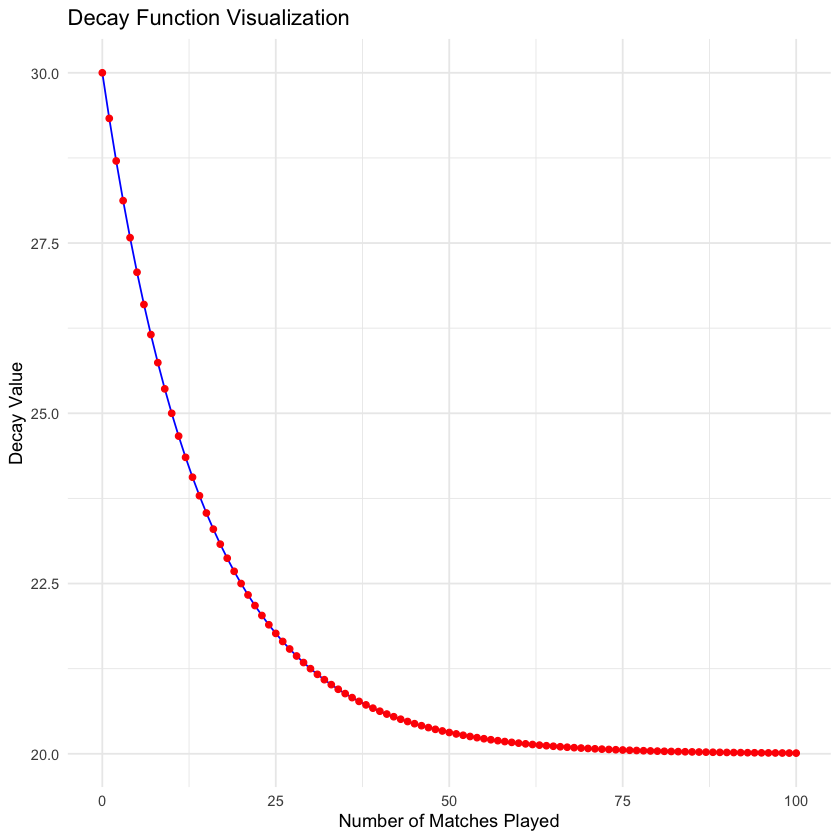

In [3]:
decay_function <- function(n_matches) {
  K_START <- 30
  K_MIN <- 20
  lambda_decay <- -log((25 - K_MIN) / (K_START - K_MIN)) / 10
  return(K_MIN + (K_START - K_MIN) * exp(-lambda_decay * n_matches))
}

# Generate data for visualization
n_matches <- 0:100  # Games played from 0 to 100
decay_values <- sapply(n_matches, decay_function)

# Create the dataframe
df <- data.frame(N_Matches = n_matches, Decay_Values = decay_values)

# Create the ggplot
p <- ggplot(df, aes(x = N_Matches, y = Decay_Values)) +
  geom_line(color = 'blue') +
  geom_point(color = 'red') +
  theme_minimal() +
  labs(title = 'Decay Function Visualization',
       x = 'Number of Matches Played',
       y = 'Decay Value')

p

**Tournament Scaling**

When games are scarce, it makes the most sense to adjust the scaling factor disproportionately for more important matches. For instance, if an individual wins the first tournament - we want ELO to consider more than just that they one a couple games in a row, but that they won against increasingly difficult players. For instance, we care more about a player winning in a tournament final than in a qualification round - especially when ELO’s aren’t stabilized. Beyond this, we also care which tournament a player is participating in. ELO should be scaled based on the hierarchy of tournaments.

**Margin of Victory**

One of the core strengths of ELO is it’s ability to compare actual margin of victory in comparison to the expected margin of victory. The margin of victory is expressed by the average point differential across each of the sets. This is important, as it recognizes games can either end in two sets, or only one. It also considers that a player could win a match, while having a negative margin of victory across the scope of the whole match. This could occur if they win the first set by only a few points, get blown out in the second set, and narrowly win in the third set. In this case, the victory is far less impressive - and they should not be rewarded for a complete victory. This system also rewards players for over-performing their ELO in a given match, and gives them a chance to actually gain ELO in situations where they are an underdog, but play up to the level of competition. To utilize margin of victory into our K-Value, we apply a logarithmic transformation that scales and normalizes the margin of victory, ensuring that it contributes appropriately to the overall rating without allowing extreme values to dominate.

**Multiplicative Scaling Factor**

To encapsulate the full scope of any given match, we multiply each of these scales. Focusing on the most important factors, we attempt to jumpstart ELO extremely quickly. For reference, the International Chess Federation has the highest possible value of K set at 40, while our dynamic ELO is capable of producing a max scaling factor upwards of 100. This is essential, as it allows our version of ELO to be incredibly sensitive early on, and become more general as more games are played. That being said, the choice to implement ELO in this way will introduce additional complexity - as the distribution of ELO rankings across the population will be inherently temporal, influenced by not only the outcome of the match, but when it took place. It also means that the matches occur prior to ELO stabilization will be entirely useless in our modelling process. 

***Dynamic Player History Features**

Given that the data is inherently temporal - historical player performance needs to be calculated retrospectively at each unique date. Each feature is only able to understand the games that came before it, rather than the players performance across the whole dataset. For these features, I will implement summary statistics across their previous 15 games, performance in previous matches against the same competitor, and their entire performance history prior to the respective date.

In [4]:
# Load Data
badminton <- read_csv("https://raw.githubusercontent.com/juanliong14/badminton_data_analysis/main/badminton_data.csv")

head(badminton,  n = 1  )

New names:
* `` -> `...1`
Rows: 14722 Columns: 30
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (25): tournament, city, country, date, tournament_type, discipline, roun...
dbl  (4): ...1, 21pts_winner, nb_sets, 11pts_winner
lgl  (1): retired

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,tournament,city,country,date,tournament_type,discipline,round,21pts_winner,nb_sets,...,game_3_scores,21pts_game_score,11pts_game_1_score,11pts_game_2_score,11pts_game_3_score,11pts_game_score,11pts_winner,21pts_winner_nationalities,11pts_winner_nationalities,point_change_eval
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
0,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,1,3,...,"['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '4-2', '5-2', '6-2', '6-3', '7-3', '7-4', '8-4', '8-5', '9-5', '10-5', '10-6', '11-6', '12-6', '12-7', '13-7', '14-7', '15-7', '16-7', '17-7', '18-7', '19-7', '20-7', '20-8', '20-9', '21-9']","['11-21', '21-18', '21-9']",7-11,9-11,11-6,"['7-11', '9-11', '11-6']",2,MAS,THA,Changed


This contains data for all BWF World Tour (2018-04/2021) tournaments. Each record is a specific match played at a tournament. The data is split up per discipline (men's singles, women's singles, men's doubles, women's doubles and mixed doubles). This specific Dataset was used for exploratory analysis regarding different scoring types. In particular, there are columns relating to an 11-point structure that isn't being utilized in the games. For the sake of our analysis, this can be ignored. We also want to remove games in which one of the players was retired. 

In [ ]:

badminton <- badminton %>%
select(tournament:`21pts_game_score`)%>%
filter(retired == "FALSE") %>%
select(-retired)
badminton$date <- dmy(badminton$date)

tail(badminton, n =1 )

Now, we will want to adjust the data types to ensure everything is documented correctly. 

In [ ]:

badminton <- badminton %>%
  mutate(winner = ifelse(`21pts_winner` == 1, team_one_players, team_two_players)) %>%
  select(-`21pts_winner`) %>%
  rename(game_1_final = `21pts_game_1_score`,
         game_2_final = `21pts_game_2_score`,
         game_3_final = `21pts_game_3_score`,
         final_score = `21pts_game_score`) 

# Viewing the first row of the modified dataframe
head(badminton, n = 1)

## Data Structure
| INFO                      | COUNT                                                                                                                                                                                                                                                                      |
|---------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Number of observations    | 14722                                                                                                                                                                                                                                                                      |
| Number of variables       | 20                                                                                                                                                                                                                                                                         |

## Variable Documentation

| Variable Name            | Data Type | Explanation                                           | Example                                                 |
|--------------------------|-----------|-------------------------------------------------------|---------------------------------------------------------|
| tournament               | chr       | Name of the tournament                                | PRINCESS SIRIVANNAVARI Thailand Masters 2018            |
| city                     | chr       | City where the tournament took place                  | Bangkok                                                 |
| country                  | chr       | Country where the tournament took place               | Thailand                                                |
| date                     | Date      | Date of the match                                     | 2018-01-09                                              |
| tournament_type          | chr       | Type or classification of the tournament              | HSBC BWF World Tour Super 300                           |
| discipline               | Factor    | Discipline/category of the match (e.g., Mens/Womens singles/doubles)      | MS                                                      |
| round                    | Factor    | Round/stage of the tournament                         | Qualification round of 16                               |
| nb_sets                  | num       | Number of sets in the match                           | 3                                                       |
| game_1_final             | chr       | Final score of the first game                         | 11-21                                                   |
| game_2_final             | chr       | Final score of the second game                        | 21-18                                                   |
| game_3_final             | chr       | Final score of the third game (if played)             | 21-9                                                    |
| team_one_players         | chr       | Player(s) in team one                                 | Jun Hao Leong                                           |
| team_two_players         | chr       | Player(s) in team two                                 | Kantawat Leelavechabutr                                 |
| team_one_nationalities   | chr       | Nationality of team one player(s)                     | MAS                                                     |
| team_two_nationalities   | chr       | Nationality of team two player(s)                     | THA                                                     |
| game_1_scores            | chr       | Score progression of the first game, stored as a sequential list.                 | ['0-0', '1-0', ...]                                     |
| game_2_scores            | chr       | Score progression of the second game, stored as a sequential list.                 | ['0-0', '0-1', ...]                                     |
| game_3_scores            | chr       | Score progression of the third game (if played), stored as a sequential list.       | ['0-0', '1-0', ...]                                     |
| final_score              | chr       | Consolidated score of all games                       | ['11-21', '21-18', '21-9']                              |
| winner                   | chr       | Player or team that won the match                     | Jun Hao Leong                                           |


In [5]:
# We need to break up the game scores

badminton <- badminton %>%
  rowwise() %>%
  mutate(
    player1_game1_score = as.numeric(str_extract(game_1_final, "^[0-9]+")),
    player2_game1_score = as.numeric(str_extract(game_1_final, "[0-9]+$")),
    player1_game2_score = as.numeric(str_extract(game_2_final, "^[0-9]+")),
    player2_game2_score = as.numeric(str_extract(game_2_final, "[0-9]+$")),
    player1_game3_score = as.numeric(str_extract(game_3_final, "^[0-9]+")),
    player2_game3_score = as.numeric(str_extract(game_3_final, "[0-9]+$")),
    player1_final_score = sum(player1_game1_score, player1_game2_score, player1_game3_score, na.rm = TRUE),
    player2_final_score = sum(player2_game1_score, player2_game2_score, player2_game3_score, na.rm = TRUE),
  ) %>%
  ungroup()



# Moving Forward We will need to seperate the various disciplines

mens_singles <- badminton %>%
    filter(discipline == "MS")
womens_singles <- badminton %>%
    filter(discipline == "WS")

mens_doubles <- badminton %>%
    filter(discipline == "MD")

womens_doubles <- badminton %>%
    filter(discipline == "WD")

mixed_doubles <- badminton %>%
    filter(discipline == "XD")




## Functions

In [6]:
# Tournament type to base K mapping
tournament_type_to_base_k <- list(
  "World Tour Finals" = 40,
  "Super 1000" = 35,
  "Super 750" = 30,
  "Super 500" = 25,
  "Super 300" = 20,
  "Super 100" = 15
)


# Function to find the base K value based on tournament type
get_base_k <- function(tournament_type) {
  for (key in names(tournament_type_to_base_k)) {
    if (str_detect(tournament_type, fixed(key))) {
      return(tournament_type_to_base_k[[key]])
    }
  }
  return(10) 
}
# Define a function to calculate the dynamic K-factor
calculate_dynamic_k <- function(tournament_type, round, margin_of_victory) {
  base_k <- get_base_k(tournament_type)
  round_multipliers <- list(
    "Final" = 1.5,
    "Semi-final" = 1.3,
    "Quarter-final" = 1.2,
    "Round of 16" = 1.1,
    "Round of 32" = 1.05,
    "Round of 64" = 1.0,
    "Round 1" = 1.0, 
    "Group" = 0.9,
    "Round 2" = 1.0,
    "Round 3" = 1.0,
    "Qualification round of 16" = 0.9,
    "Qualification round of 32" = 0.85, 
    "Qualification quarter final" = 0.95,
    "Round of 64" = 1.0
  )
  round_multiplier <- round_multipliers[[round]] %||% 1.0
  margin_multiplier <- log1p(margin_of_victory) / log1p(10)
  dynamic_k <- base_k * round_multiplier * margin_multiplier
  return(dynamic_k)
}

# Define the decay function for the K-factor
# This means if a player doesn't play for a while, they will lose elo
decay_function <- function(n_matches) {
  K_START <- 30
  K_MIN <- 20
  lambda_decay <- -log((25 - K_MIN) / (K_START - K_MIN)) / 10
  return(K_MIN + (K_START - K_MIN) * exp(-lambda_decay * n_matches))
}

# Define function to calculate expected score
expected_score <- function(player_elo, opponent_elo) {
  return(1 / (1 + exp((opponent_elo - player_elo) / 400)))
}

# Elo rating update with time-dependent dynamic K-factor
# Elo rating update with time-dependent dynamic K-factor
update_elo <- function(player1_elo, player2_elo, player1_score, player2_score, player1_matches, player2_matches, nb_sets, tournament_type, round, player1_wins) {
  margin_of_victory <-  (abs(player1_score - player2_score) / nb_sets)

  dynamic_k <- calculate_dynamic_k(tournament_type, round, margin_of_victory)
  
  # Calculate time-dependent dynamic K-factor for both players
  time_dependent_k_player1 <- decay_function(player1_matches)
  time_dependent_k_player2 <- decay_function(player2_matches)
  
  # Calculate final K-factor for both players
  final_k_player1 <- dynamic_k * time_dependent_k_player1 / 20
  final_k_player2 <- dynamic_k * time_dependent_k_player2 / 20
  
  # Calculate expected scores
  expected_player1 <- expected_score(player1_elo, player2_elo)
  expected_player2 <- expected_score(player2_elo, player1_elo)
  
  # Calculate actual scores based on who wins
  actual_player1 <- ifelse(player1_wins, 1, 0)
  actual_player2 <- ifelse(player1_wins, 0, 1)
  
  # Update Elo ratings
  player1_elo_new <- player1_elo + (final_k_player1 * (actual_player1 - expected_player1))
  player2_elo_new <- player2_elo + (final_k_player2 * (actual_player2 - expected_player2))
  
  return(list(player1_elo_new = player1_elo_new, player2_elo_new = player2_elo_new))
}


In [7]:

# Initialize Elo ratings for men's singles players
players_ms <- unique(c(mens_singles$team_one_players, mens_singles$team_two_players))
elo_ratings_ms <- setNames(rep(1500, length(players_ms)), players_ms)
matches_played_ms <- setNames(rep(0, length(players_ms)), players_ms)

elo_history <- data.frame(player = character(),
                          date = as.Date(character()),
                          elo_rating = numeric(),
                          stringsAsFactors = FALSE)



elo_before_player1 <- numeric(nrow(mens_singles))
elo_before_player2 <- numeric(nrow(mens_singles))
elo_after_player1 <- numeric(nrow(mens_singles))
elo_after_player2 <- numeric(nrow(mens_singles))

# Loop through each match to update Elo ratings
for (i in 1:nrow(mens_singles)) {
  # Extract information for the current match
  current_match <- mens_singles[i, ]
  
  # Get player names
  player1 <- current_match$team_one_players
  player2 <- current_match$team_two_players
  
  # Get Elo ratings before the match for both players
  elo_before_player1[i] <- elo_ratings_ms[player1]
  elo_before_player2[i] <- elo_ratings_ms[player2]
  
  
  
  # Determine the match winner
  player1_wins <- current_match$winner == player1
  
  # Update Elo ratings
  updates <- update_elo(
    elo_before_player1[i],
    elo_before_player2[i],
    current_match$player1_final_score,
    current_match$player2_final_score,
    matches_played_ms[player1],
    matches_played_ms[player2],
    current_match$nb_sets,
    current_match$tournament_type,
    as.character(current_match$round),
    player1_wins
  )
  
  # Store updated Elo ratings after the match
  elo_after_player1[i] <- updates$player1_elo_new
  elo_after_player2[i] <- updates$player2_elo_new
  
  # Update global Elo ratings and match counts
  elo_ratings_ms[player1] <- updates$player1_elo_new
  elo_ratings_ms[player2] <- updates$player2_elo_new
  matches_played_ms[player1] <- matches_played_ms[player1] + 1
  matches_played_ms[player2] <- matches_played_ms[player2] + 1

  elo_history <- rbind(elo_history, data.frame(player = player1,
                                               date = current_match$date,
                                               elo_rating = updates$player1_elo_new))
  elo_history <- rbind(elo_history, data.frame(player = player2,
                                               date = current_match$date,
                                               elo_rating = updates$player2_elo_new))
}

# Bind the new Elo rating columns to the mens_singles dataframe
mens_singles <- mens_singles %>%
  mutate(
    elo_before_player1 = elo_before_player1,
    elo_before_player2 = elo_before_player2,
    elo_after_player1 = elo_after_player1,
    elo_after_player2 = elo_after_player2
  )


head(mens_singles)


tournament,city,country,date,tournament_type,discipline,round,nb_sets,game_1_final,game_2_final,...,player1_game2_score,player2_game2_score,player1_game3_score,player2_game3_score,player1_final_score,player2_final_score,elo_before_player1,elo_before_player2,elo_after_player1,elo_after_player2
<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,2018-01-09,HSBC BWF World Tour Super 300,MS,Qualification round of 16,3,11-21,21-18,...,21,18,21,9,53,48,1500,1500,1505.522,1494.478
PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,2018-01-09,HSBC BWF World Tour Super 300,MS,Qualification round of 16,2,21-7,21-18,...,21,18,NA,NA,42,25,1500,1500,1512.675,1487.325
PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,2018-01-09,HSBC BWF World Tour Super 300,MS,Qualification round of 16,3,21-16,8-21,...,8,21,23,21,52,58,1500,1500,1506.185,1493.815
PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,2018-01-09,HSBC BWF World Tour Super 300,MS,Qualification round of 16,2,21-17,21-7,...,21,7,NA,NA,42,24,1500,1500,1512.963,1487.037
PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,2018-01-09,HSBC BWF World Tour Super 300,MS,Qualification round of 16,2,13-21,13-21,...,13,21,NA,NA,26,42,1500,1500,1487.630,1512.370
PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,2018-01-09,HSBC BWF World Tour Super 300,MS,Qualification round of 16,2,19-21,21-23,...,21,23,NA,NA,40,44,1500,1500,1493.815,1506.185


## Plotting ELO progression of top 10 players

In [8]:
options(repr.plot.width=25, repr.plot.height=10)
final_elo_ratings <- elo_history %>% 
  group_by(player) %>% 
  summarize(final_elo = last(elo_rating)) %>% 
  arrange(desc(final_elo))

# Select the top 10 players
top_players <- head(final_elo_ratings, 10)$player

# Filter the elo_history for only these top players
elo_history_top_players <- elo_history %>% 
  filter(player %in% top_players)



Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


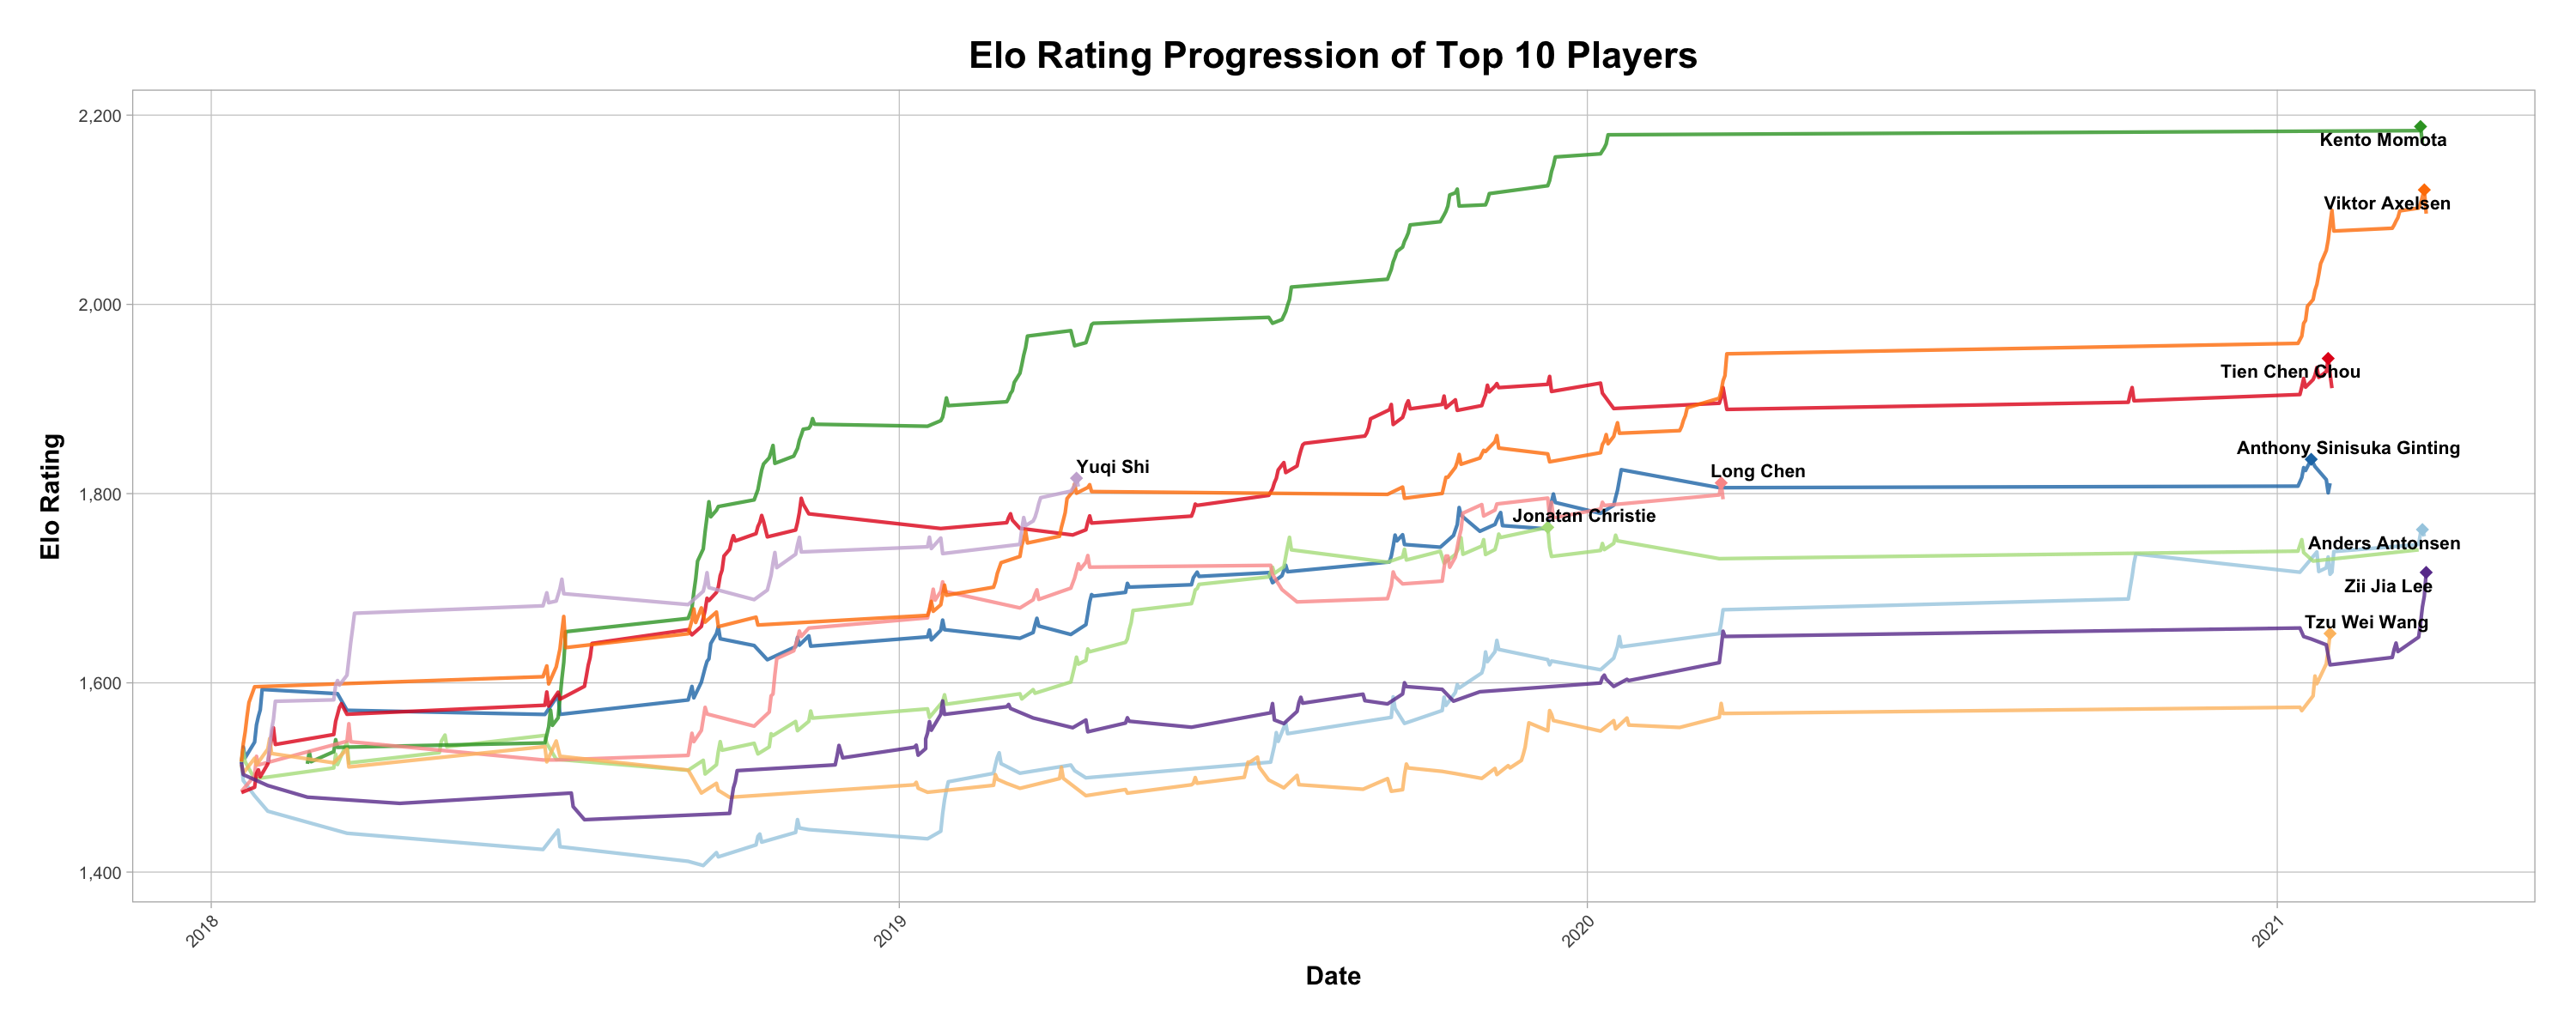

In [9]:
options(repr.plot.width=25, repr.plot.height=10)
library(ggrepel)
library(scales)
library(gghighlight)
library(RColorBrewer)
library(ggthemes)
color_palette <- brewer.pal(n = 10, name = "Paired")

# Filter the last rating for each player
last_ratings <- elo_history_top_players %>%
  group_by(player) %>%
  filter(date == max(date)) %>%
  ungroup()



options(repr.plot.width=25, repr.plot.height=10)
color_palette <- brewer.pal(n = 10, name = "Paired")

elo_history_top_players <- elo_history_top_players %>%
  group_by(player) %>%
  mutate(is_peak = ifelse(elo_rating == max(elo_rating), TRUE, FALSE)) %>%
  ungroup()


label_positions <- elo_history_top_players %>%
  filter(is_peak) %>%
  group_by(player) %>%
  slice_max(order_by = date, n = 1) %>%
  ungroup()


elo_plot_improved <- ggplot(elo_history_top_players, aes(x = date, y = elo_rating, group = player)) +
  geom_line(aes(color = player), size = 1.2, alpha = 0.8) + 
  geom_point(data = label_positions, aes(color = player), size = 4, shape = 18) + 
  geom_text_repel(
    data = label_positions,
    aes(label = player), 
    size = 4.5, 
    fontface = 'bold',
    box.padding = unit(0.25, "lines"),
    point.padding = unit(0.3, "lines"),
    segment.color = 'grey50'
  ) +
  scale_color_manual(values = color_palette) +
  labs(
    title = "Elo Rating Progression of Top 10 Players",
    x = "Date",
    y = "Elo Rating"
  ) +
  theme_light(base_size = 16) +
  theme(
    plot.title = element_text(size = 26, face = "bold", hjust = 0.5, margin = margin(b = 10)),
    axis.title.x = element_text(size = 18, face = "bold", margin = margin(t = 10)),
    axis.title.y = element_text(size = 18, face = "bold", margin = margin(r = 10)),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12),
    legend.position = "none",
    panel.grid.major = element_line(color = "grey80"),
    panel.grid.minor = element_blank(),
    plot.margin = unit(c(1, 1, 1, 1), "cm")
  ) +
  scale_y_continuous(labels = label_comma())


print(elo_plot_improved)


Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 30 rows containing missing values (`geom_smooth()`)."


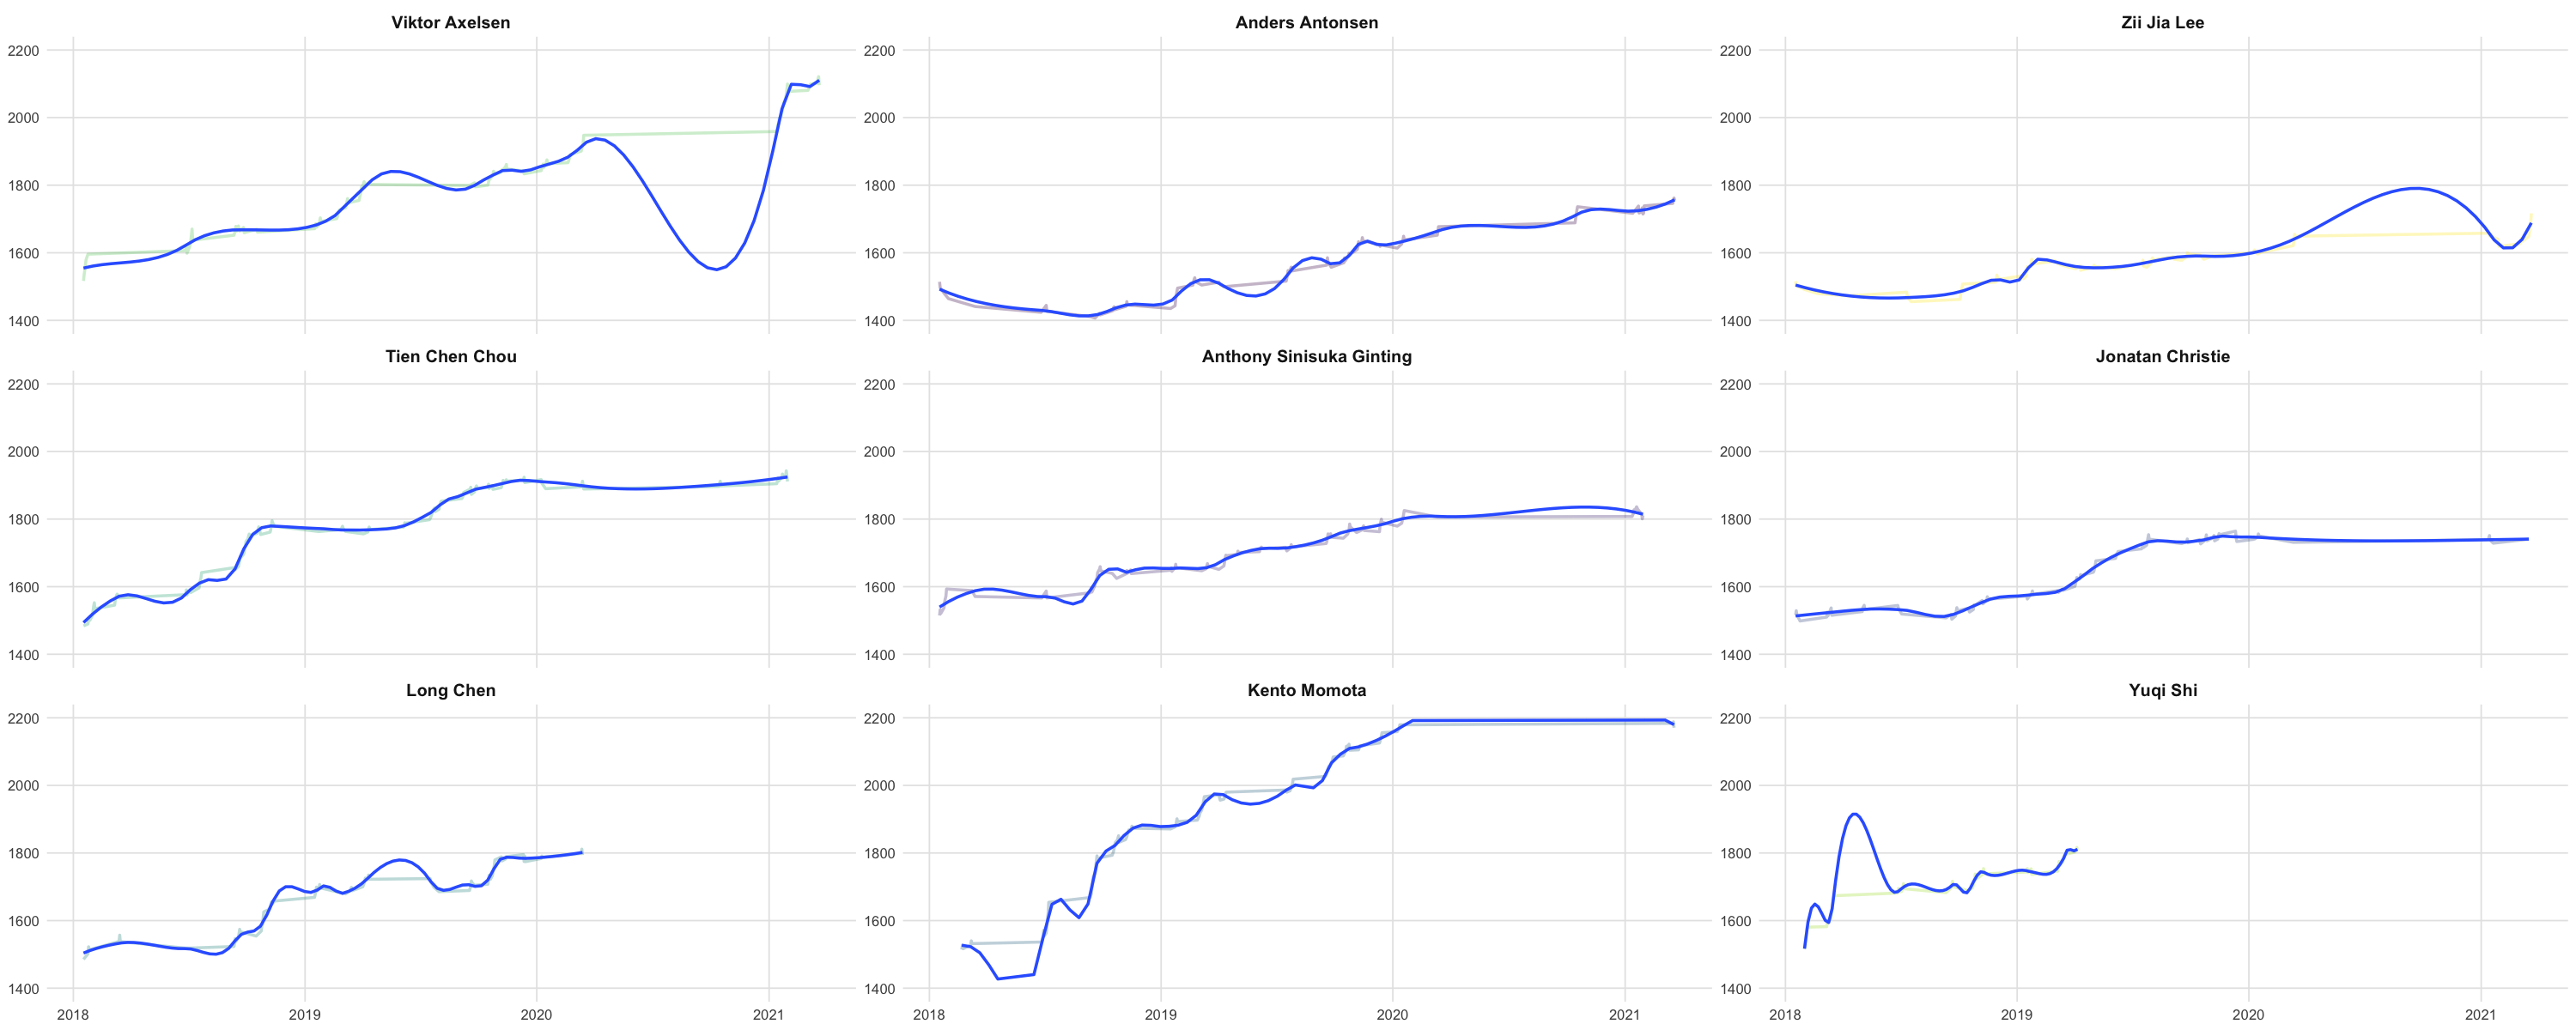

In [10]:
library(ggplot2)
library(dplyr)
library(ggrepel)


latest_elos <- elo_history_top_players %>%
  group_by(player) %>%
  summarize(latest_elo = last(elo_rating, order_by = date)) %>%
  ungroup()

# Determine the top 9 players based on their latest Elo ratings
top_players <- latest_elos %>%
  top_n(9, latest_elo) %>%
  pull(player)

# Filter the Elo history for these top 9 players
elo_top_players <- elo_history_top_players %>%
  filter(player %in% top_players)

# Create a faceted Elo plot for the top 9 players
elo_faceted_plot <- ggplot(elo_top_players, aes(x = date, y = elo_rating, group = player)) +
  geom_line(aes(color = player), size = 1, alpha = 0.3) + 
  geom_smooth(se = FALSE, method = 'loess', span = 0.2) + 
  facet_wrap(~ fct_reorder(player, date, .desc = TRUE), scales = "free_y", ncol = 3) + 
  theme_minimal() +
  theme(
    strip.background = element_blank(), 
    strip.text.x = element_text(size = 12, face = "bold"), 
    axis.text.x = element_text(size = 10),
    axis.text.y = element_text(size = 10),
    axis.title.x = element_blank(), 
    axis.title.y = element_blank(),
    panel.grid.major = element_line(color = "grey90", size = 0.5), 
    panel.grid.minor = element_blank(), 
    legend.position = "none" 
  ) +
  scale_y_continuous(limits = c(1400, 2200)) +
  scale_color_viridis_d() 


print(elo_faceted_plot)

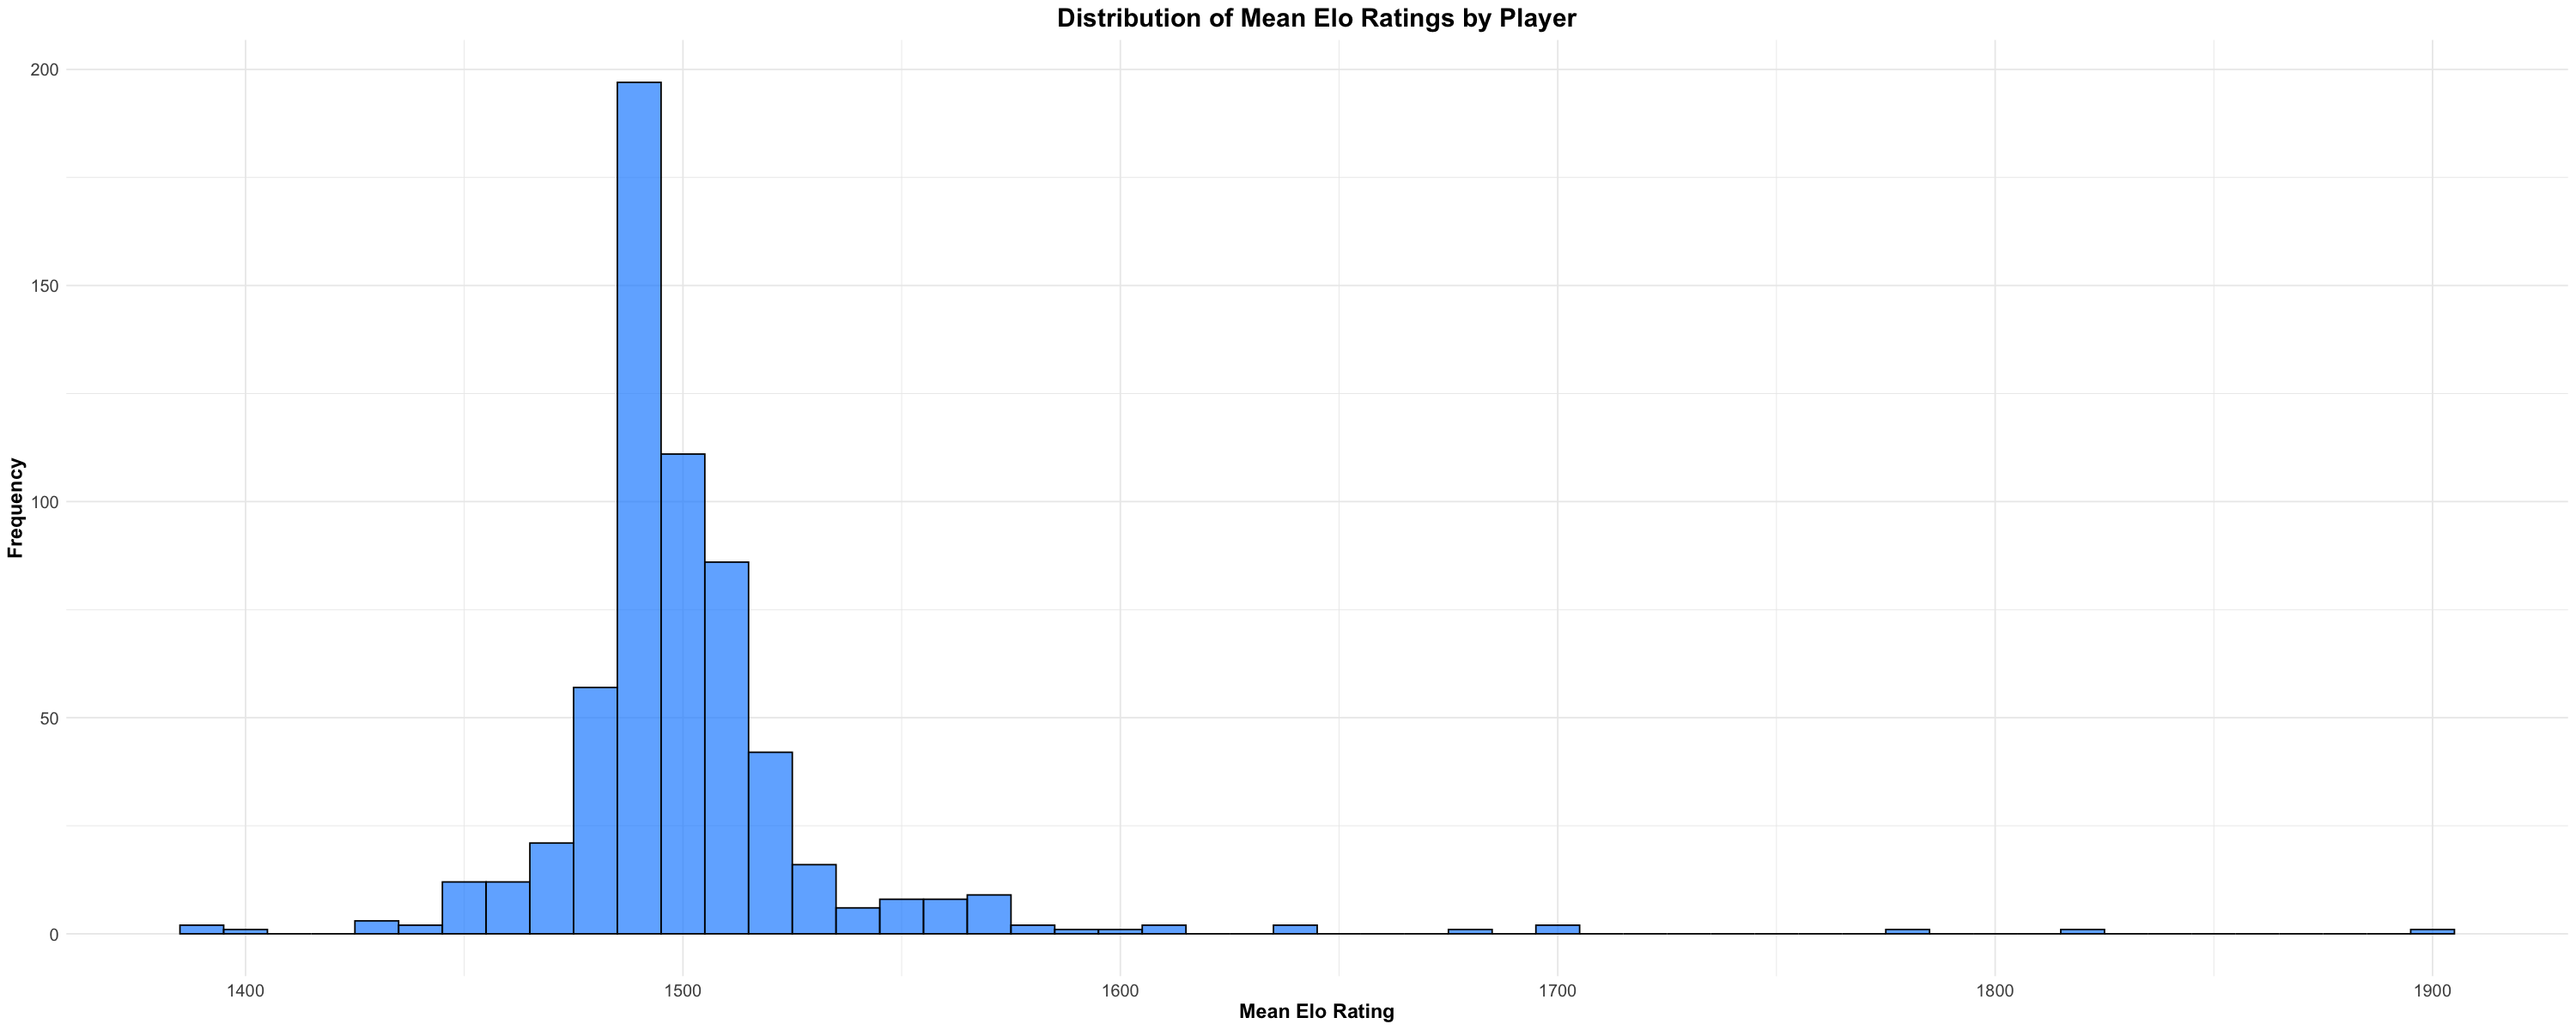

In [11]:
## Distribution

elo_distributions <- elo_history %>%
group_by(player)%>%
summarise(mean_elo = mean(elo_rating))


#  histogram plot
ggplot(elo_distributions, aes(x = mean_elo)) +
  geom_histogram(binwidth = 10, fill = "dodgerblue", color = "black", alpha = 0.7) + 
  labs(
    x = "Mean Elo Rating",
    y = "Frequency",
    title = "Distribution of Mean Elo Ratings by Player",
  ) +
  theme_minimal() +  
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(size = 14, hjust = 0.5),
    plot.caption = element_text(hjust = 0),
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14, face = "bold"),
    legend.position = "none"  
  )


## Modelling Methods

For probability-based classification of win probability using your dataset, XGBoost (Gradient Boosted Decision Trees) are a strong choice due to its inherent ability to output well-calibrated class probabilities with complex, non linear feautures.

### XGBoost for Probability-Based Classification

1. **Why Appropriate**: XGBoost can provide probability estimates for the win/loss outcome (denoted by the `winner` variable) when configured for classification. The algorithm does this by outputting a score derived from the ensemble of trees, which can be converted into a probability using a logistic function.

2. **Dataset Variables Usage**: The model can incorporate ELO ratings, tournament type (`tournament_type`), discipline (`discipline`), round (`round`), and the number of sets (`nb_sets`) as features. These features will help the model learn from historical outcomes to predict the winning probability before the match starts.

### Assumptions Required

1. **Calibration of Probabilities**: It assumes that with proper calibration, the predicted probabilities will reflect true likelihoods of outcomes.
2. **Independent and Identically Distributed Data**: Assumes each instance in the dataset is independent from others, an assumption that might not always hold in sequences of games due to potential psychological and physical influences (such as injury, exhaustion, aging) on players.

### Potential Limitations or Weaknesses

1. **Calibration Requirement**: While XGBoost is capable of producing probability estimates, these may need to be calibrated to reflect true probabilities accurately.
2. **Complexity and Interpretability**: The complex model structure can make it difficult to interpret how probabilities are derived from input features directly.
3. **Dynamic Nature of Sports**: The model may not capture the temporal dynamics unless features that account for time-series effects are included.
4. **ELO Rating Concerns**: Given that all ELO ratings begin at zero, the distribution of ELO ratings is not consistent across different time periods


### Hyperparameter Optimization and Model Validation
1. **Hyperparameter Tuning**: Critical for optimal performance. Parameters like learning rate, tree depth, and regularization terms need careful adjustment.
2. **Cross-Validation**: Implementing techniques like k-fold cross-validation ensures that the model's effectiveness is not limited to a specific subset of data.
3. **Minimizing Overfitting**: Regularization parameters within XGBoost, alongside cross-validation, help in avoiding overfitting, ensuring the model generalizes well to new data.

### Assessing Model Effectiveness

1. **Brier Score**: This metric is useful for evaluating how close the probability predictions are to the actual outcomes.

2. **Calibration Curves**: These will assess how well the predicted probabilities of winning align with the actual outcomes.

3. **Subsetting Training/Testing Data:** Our predictions aren’t likely to be effective in the early phases of our dataset, where players have only played a couple of games. Our evaluation of the model should be with respect to how it performs as the number of games increases. 

In summary, XGBoost is an optimal choice for predicting win probabilities in badminton matches, leveraging its strength in handling complex, non-linear relationships within the dataset. It requires careful hyperparameter tuning and validation, including cross-validation and calibration, to ensure accuracy and minimize overfitting. Further feature engineering may be necessary to maximize the models performance. XGBoost's ability to provide well-calibrated probability estimates makes it highly suitable for our prediction goals.

To assert the strength of XGBOOST, I will compare it to a logistic regression model.


# Implementation of a proposed model

### Additional Feauture Engineering

In [12]:

mens_singles <- mens_singles %>%
  mutate(
    player1_diff_per_set = (player1_final_score - player2_final_score) / nb_sets,
    player1_points_percentage = player1_final_score / (player1_final_score + player2_final_score),
    player2_diff_per_set = (player2_final_score - player1_final_score) / nb_sets,
    player2_points_percentage = player2_final_score / (player2_final_score + player1_final_score)
  ) %>%
  rename(player1 = team_one_players, 
         player2 = team_two_players) %>%
  mutate(player1_set_1_win = ifelse( player1_game1_score > player2_game1_score, 1, 0), 
         player2_set_1_win = ifelse( player2_game1_score > player1_game1_score, 1, 0),
         player1_set_2_win = ifelse( player1_game2_score > player2_game2_score, 1, 0), 
         player2_set_2_win = ifelse( player2_game2_score > player1_game2_score, 1, 0),
         player1_set_3_win = ifelse( nb_sets  == 3 , 
                                     ifelse(player1_game3_score > player2_game3_score, 1, 0), 0), 
         player2_set_3_win = ifelse(nb_sets  == 3 , 
                                     ifelse(player2_game3_score > player1_game3_score, 1, 0), 0)) %>%
  mutate(player_1_set_wins = player1_set_1_win + player1_set_2_win + player1_set_3_win, 
         player_2_set_wins = nb_sets - player_1_set_wins)

**Feauture Engineering Functions**

In [13]:
get_player_games <- function(df, player_name, index ) {
  # Subset for games where the player was player1
  p1_games_p1 <- subset(df[1:index - 1, ], player1 == player_name) %>%
    rename(name = player1, opponent  = player2, player_elo = elo_before_player1, opponent_elo  = elo_before_player2,
           score = player1_final_score, opponent_score = player2_final_score,
           avg_set_difference = player1_diff_per_set, points_percentage = player1_points_percentage, 
           set_wins = player_1_set_wins) %>%
    mutate(win = ifelse(name == winner, TRUE, FALSE)) %>%
    select(tournament:nb_sets, name, opponent, win, set_wins,  player_elo, opponent_elo, score, opponent_score, 
           avg_set_difference, points_percentage)
  
  # Subset for games where the player was player2
  p1_games_p2 <- subset(df[1:index - 1, ], player2 == player_name) %>%
    rename(name = player2, opponent  = player1, player_elo = elo_before_player2, opponent_elo  = elo_before_player1,
           score = player2_final_score, opponent_score = player1_final_score,
           avg_set_difference = player2_diff_per_set, points_percentage = player2_points_percentage,
           set_wins = player_2_set_wins) %>%
    mutate(win = ifelse(name == winner, TRUE, FALSE)) %>%
    select(tournament:nb_sets, name, opponent, win,set_wins,  player_elo, opponent_elo, score, opponent_score, 
           avg_set_difference, points_percentage)
  
  # Combine and arrange the games
  p1_games <- bind_rows(p1_games_p1, p1_games_p2) %>%
    arrange(desc(date))
  
  return(p1_games)
}

calculate_last_15_summary <- function(games) {
  # Check if there are at least 15 games
  if (nrow(games) >= 15) {
    # Select the last 15 games
    last_15_games <- head(games, 15)
    game_order <- seq_len(nrow(last_15_games))
    # Calculate the slope of ELO rating over the last 15 games
    elo_slope <- lm(player_elo ~ game_order, data = last_15_games)$coefficients[["game_order"]]
    
    # Summarize last 15 games statistics
    last_15_summary <- last_15_games %>%
      summarize(
        wins_last_15 = sum(win == TRUE), 
        losses_last_15 = sum(win == FALSE),
        win_percentage_last_15 = wins_last_15 / (wins_last_15 + losses_last_15),
        set_win_percentage_last_15 = sum(set_wins) / sum(nb_sets), 
        avg_set_diff_last_15 = mean(avg_set_difference),
        point_win_percentage_last_15 = sum(score) / (sum(score) + sum(opponent_score)),
        elo_lm_slope_last_15 = elo_slope,
        elo_slope_ends = (first(player_elo) - last(player_elo))/15
      )
  } else {
    # If less than 15 games, set values to -1 and slope to NA
    last_15_summary <- data.frame(
      wins_last_15 = -1, 
      losses_last_15 = -1,
      win_percentage_last_15 = -1,
      set_win_percentage_last_15 = -1,
      avg_set_diff_last_15 = -1,
      point_win_percentage_last_15 = -1, 
      elo_lm_slope_last_15 = 0, 
      elo_slope_ends = 0
    )
  }
  
  return(last_15_summary)
}

get_player_head_to_head <- function(p1_games, opponent_name){
  
  head_to_head <- p1_games%>%
    filter(opponent == opponent_name)
  
  if(nrow(head_to_head) > 0 ){
    head_to_head <- head_to_head%>%
      summarise(wins = sum(win == TRUE ), 
                loses = sum(win == FALSE),
                win_percentage = wins / (wins+loses),
                set_win_percentage = sum(set_wins) / sum(nb_sets), 
                avg_set_diff = mean(avg_set_difference),
                point_win_percentage = sum(score) / (sum(score) + sum(opponent_score)))
    
  }else{
    head_to_head <- head_to_head%>%
      summarise(
        wins = -1, 
        loses = -1,
        win_percentage = -1,
        set_win_percentage = -1, 
        avg_set_diff = -1,
        point_win_percentage = -1)
    
    
  }
  return(head_to_head)
}

get_career_summary <- function(p1_games){
  if (nrow(p1_games) > 0){
    p1_summary <-  p1_games %>%
      summarize(wins = sum(win == TRUE ), 
                loses = sum(win == FALSE),
                win_percentage = wins / (wins+loses),
                set_win_percentage= sum(set_wins) / sum(nb_sets), 
                avg_set_diff = mean(avg_set_difference),
                point_win_percentage = sum(score) / (sum(score) + sum(opponent_score)))
  }else{
    p1_summary <-  p1_games %>%
      summarise(
        wins = -1, 
        loses = -1,
        win_percentage = -1,
        set_win_percentage = -1, 
        avg_set_diff = -1,
        point_win_percentage = -1)
    }
  
  return(p1_summary)
}


**Feature Engineering Loop**
- Iterating through each game, and calculating features based on only the games that took place previously

In [ ]:
singles <- mens_singles %>%
  mutate(
         p1_career_win_percentage = 0,
         p1_career_set_win_percentage = 0, 
         p1_career_avg_set_diff = 0,
         p1_career_point_win_percentage = 0,
         p2_career_win_percentage = 0,
         p2_career_set_win_percentage = 0, 
         p2_career_avg_set_diff = 0,
         p2_career_point_win_percentage = 0, 
         p1_win_percentage_last_15 = 0,
         p1_set_win_percentage_last_15 = 0,
         p1_avg_set_diff_last_15 = 0,
         p1_point_win_percentage_last_15 = 0, 
         p1_elo_lm_slope_last_15 = 0, 
         p1_elo_slope_ends = 0, 
         p2_win_percentage_last_15 = 0,
         p2_set_win_percentage_last_15 = 0,
         p2_avg_set_diff_last_15 = 0,
         p2_point_win_percentage_last_15 = 0, 
         p2_elo_lm_slope_last_15 = 0, 
         p2_elo_slope_ends = 0, 
         h2h_wins = 0, 
         h2h_loses = 0,
         h2h_win_percentage = 0,
         h2h_set_win_percentage = 0, 
         h2h_avg_set_diff = 0,
         h2h_point_win_percentage = 0
         )

n_iter <- nrow(singles)
pb <- txtProgressBar(min = 0, max = n_iter, style = 3, width = 50, char = "=")
init <- numeric(n_iter)
end <- numeric(n_iter)

for(i in 1:nrow(singles)){
  init[i] <- Sys.time()
  p1_name = mens_singles$player1[i]
  p2_name = mens_singles$player2[i]
  
  p1_games <- get_player_games(singles, player_name = p1_name, index = i)
  p2_games <- get_player_games(singles, player_name = p2_name, index = i)
  
  p1_summary <- get_career_summary(p1_games)
  p2_summary <- get_career_summary(p2_games)
  
  p1_L15 <- calculate_last_15_summary(p1_games)
  p2_L15 <- calculate_last_15_summary(p2_games)
  
  h2h <- get_player_head_to_head(p1_games, p2_name)
  
  singles$p1_career_win_percentage[i] = p1_summary$win_percentage[1] 
  singles$p1_career_set_win_percentage[i] = p1_summary$set_win_percentage[1] 
  singles$p1_career_avg_set_diff[i] = p1_summary$avg_set_diff[1]  
  singles$p1_career_point_win_percentage[i] = p1_summary$point_win_percentage[1] 
  singles$p2_career_win_percentage[i] = p2_summary$win_percentage[1] 
  singles$p2_career_set_win_percentage[i] = p2_summary$set_win_percentage[1] 
  singles$p2_career_avg_set_diff[i] = p2_summary$avg_set_diff[1] 
  singles$p2_career_point_win_percentage[i] = p2_summary$point_win_percentage[1] 
  singles$p1_win_percentage_last_15[i] = p1_L15$win_percentage_last_15[1]  
  singles$p1_set_win_percentage_last_15[i] = p1_L15$set_win_percentage_last_15[1] 
  singles$p1_avg_set_diff_last_15[i] = p1_L15$avg_set_diff_last_15[1] 
  singles$p1_point_win_percentage_last_15[i] = p1_L15$point_win_percentage_last_15[1] 
  singles$p1_elo_lm_slope_last_15[i] = p1_L15$elo_lm_slope_last_15[1] 
  singles$p1_elo_slope_ends[i] = p1_L15$elo_slope_ends[1] 
  singles$p2_win_percentage_last_15[i] = p2_L15$win_percentage_last_15[1]  
  singles$p2_set_win_percentage_last_15[i] = p2_L15$set_win_percentage_last_15[1] 
  singles$p2_avg_set_diff_last_15[i] = p2_L15$avg_set_diff_last_15[1] 
  singles$p2_point_win_percentage_last_15[i] = p2_L15$point_win_percentage_last_15[1] 
  singles$p2_elo_lm_slope_last_15[i] = p2_L15$elo_lm_slope_last_15[1] 
  singles$p2_elo_slope_ends[i] = p2_L15$elo_slope_ends[1] 
  singles$h2h_wins[i] = h2h$wins[1] 
  singles$h2h_loses[i] = h2h$loses[1]  
  singles$h2h_win_percentage[i] =h2h$win_percentage[1]   
  singles$h2h_set_win_percentage[i] = h2h$set_win_percentage[1] 
  singles$h2h_avg_set_diff[i] = h2h$avg_set_diff[1] 
  singles$h2h_point_win_percentage[i] = h2h$point_win_percentage
  
  end[i] <- Sys.time()
  setTxtProgressBar(pb, i)
  time <- round(seconds_to_period(sum(end - init)), 0)
  est <- n_iter * (mean(end[end != 0] - init[init != 0])) - time
  remaining <- round(seconds_to_period(est), 0)
  cat(paste("\rExecution time:", time,
            "// Estimated time remaining:", remaining), fill = TRUE)
}
close(pb)


# Initialize columns for total games
singles$p1_career_games <- 0
singles$p2_career_games <- 0

# Create a list to keep track of the number of games played by each player
player_games_count <- list()


for (i in 1:nrow(singles)) {
  p1_name <- singles$player1[i]
  p2_name <- singles$player2[i]
  
  # Increment game count for player1
  if (!is.null(player_games_count[[p1_name]])) {
    player_games_count[[p1_name]] <- player_games_count[[p1_name]] + 1
  } else {
    player_games_count[[p1_name]] <- 1
  }
  
  # Increment game count for player2
  if (!is.null(player_games_count[[p2_name]])) {
    player_games_count[[p2_name]] <- player_games_count[[p2_name]] + 1
  } else {
    player_games_count[[p2_name]] <- 1
  }
  
  # Assign the total games played by each player prior to this game
  singles$p1_career_games[i] <- player_games_count[[p1_name]] - 1 # Subtract 1 as this game hasn't finished yet
  singles$p2_career_games[i] <- player_games_count[[p2_name]] - 1 # Same reasoning as above
}

**Encoding Categorical Feautures**

In [15]:

tournament_importance <- c(
  "HSBC BWF World Tour Finals" = 6,
  "HSBC BWF World Tour Super 1000" = 5,
  "HSBC BWF World Tour Super 750" = 4,
  "HSBC BWF World Tour Super 500" = 3,
  "HSBC BWF World Tour Super 300" = 2,
  "BWF Tour Super 100" = 1
)
singles$tournament_ordinal <- sapply(singles$tournament_type, function(x) tournament_importance[x])

round_importance <- c(
  "Qualification round of 32" = 1,
  "Qualification round of 16" = 2,
  "Qualification quarter final" = 3,
  "Round of 64" = 4,
  "Round 1" = 5,  # Assuming Round 1 is early in the tournament
  "Round 2" = 6,
  "Round 3" = 7,
  "Round of 32" = 8,
  "Round of 16" = 9,
  "Quarter final" = 10,
  "Semi final" = 11,
  "Final" = 12
)
singles$round_ordinal <- sapply(singles$round, function(x) round_importance[x])


df <- singles %>%
  mutate(p1_win = ifelse(winner == player1, 1, 0))%>%
  mutate(elo_diff = elo_before_player1 - elo_before_player2) %>%
  select(tournament_ordinal, round_ordinal, elo_before_player1, elo_before_player2, elo_diff,
         p1_career_games, p2_career_games, p1_career_win_percentage:h2h_point_win_percentage, p1_win)
  

## Model Building

1. **Logistic Regression**

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


[1] 0.2267464

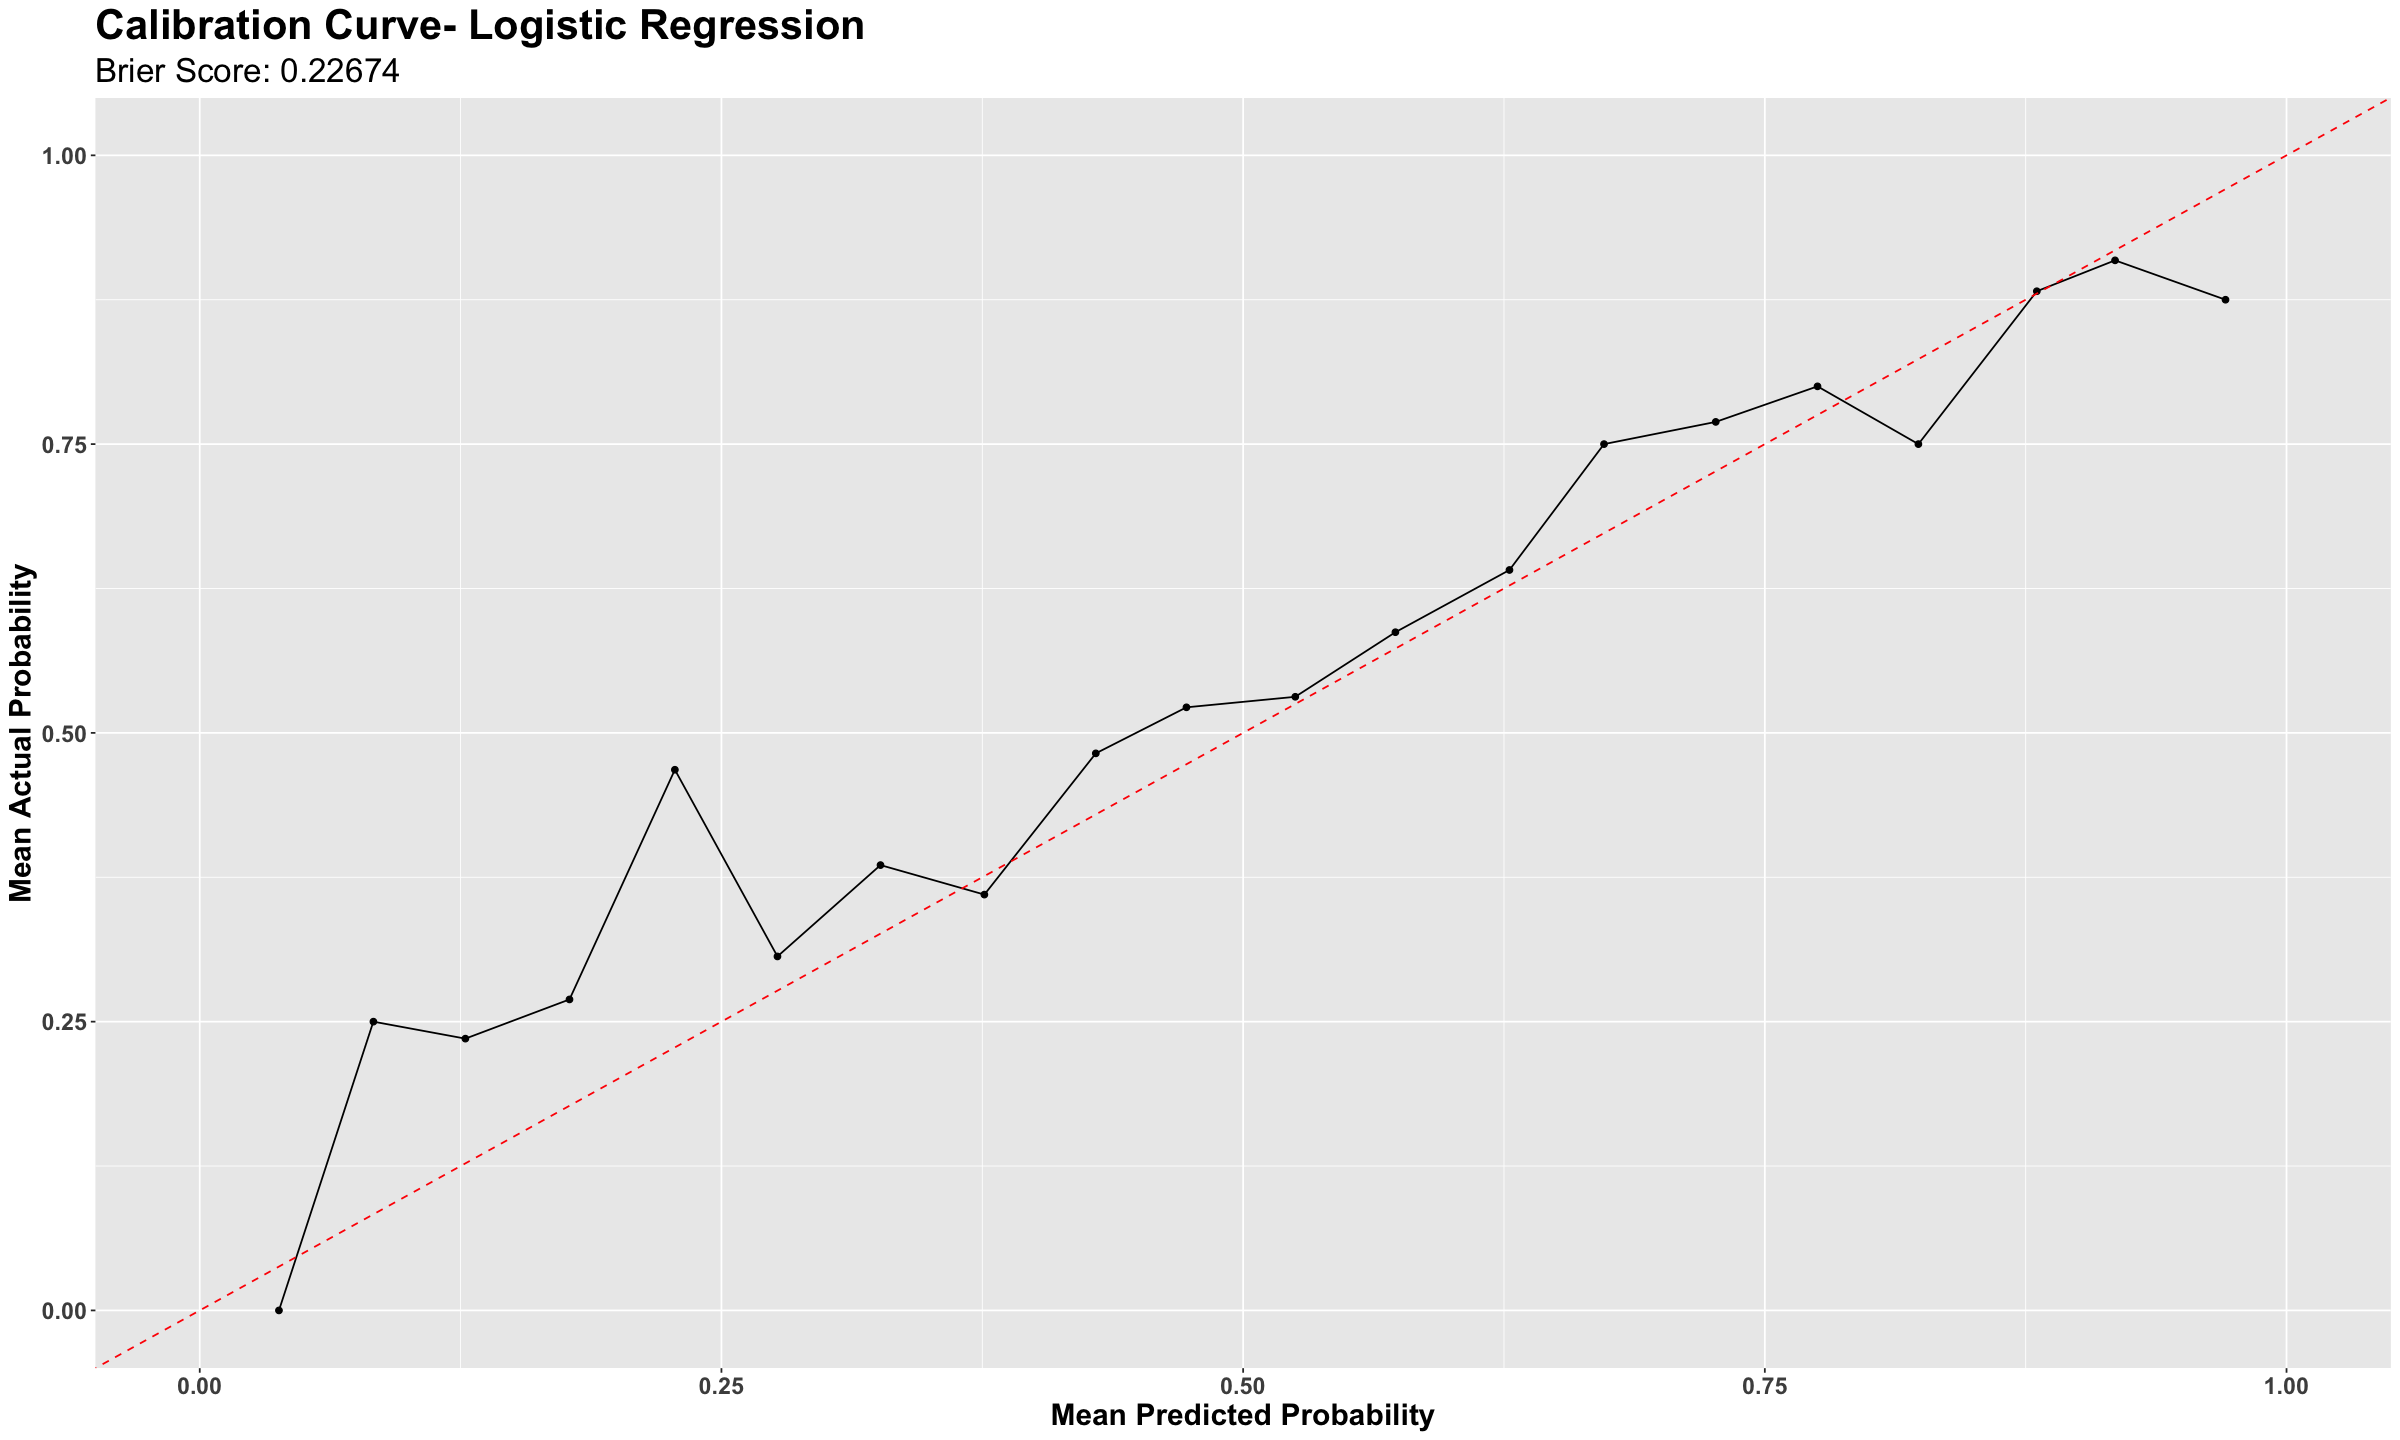

In [40]:
options(repr.plot.width=20, repr.plot.height=12)
set.seed(123) # For reproducibility

splitIndex <- createDataPartition(df$p1_win, p = 0.7, list = FALSE)
train <- df[splitIndex,]
test <- df[-splitIndex,]

# LOGISTIC REGRESSION
model <- glm(p1_win ~ ., data = train, family = binomial)

# Predicting probabilities on the test set
predicted_probabilities <- predict(model, newdata = test, type = "response")

brier_score <- mean((predicted_probabilities - test$p1_win)^2)
brier_score # it's 0.2271012

test$predicted_probability <- predicted_probabilities

# Creating bins for the calibration curve
test$predicted_bin <- cut(test$predicted_probability, breaks = seq(0, 1, by = 0.05))

# Calculating mean predicted probability and actual probability in each bin
calibration_data <- test %>%
  group_by(predicted_bin) %>%
  summarise(mean_predicted = mean(predicted_probability),
            mean_actual = mean(p1_win))

# Plotting the calibration curve
ggplot(calibration_data, aes(x = mean_predicted, y = mean_actual)) +
  geom_point() +
  geom_line() +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
  xlim(c(0, 1)) + ylim(c(0, 1)) +
  xlab("Mean Predicted Probability") + ylab("Mean Actual Probability") +
  ggtitle("Calibration Curve- Logistic Regression", subtitle = "Brier Score: 0.22674")+
  theme(
    plot.title = element_text(size = 25, face = "bold"),
    plot.subtitle = element_text(size = 20, face = "plain"),
    axis.title.x = element_text(size = 18, face = "bold"),
    axis.title.y = element_text(size = 18, face = "bold"), 
    axis.text.x = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold")
  )



Generally, the Logistic regression model does a decent job at estimating win probability - and is extremely strong near the center of the data. 

Brier Score = 0.22674644033928

**XGBOOST**


In [35]:
# Error was caused by logistic testing eval
dt <- test %>%
    select(-c('predicted_probability', 'predicted_bin'))

dtrain <- xgb.DMatrix(data = as.matrix(train[, -ncol(train)]), label = train$p1_win)
dtest <- xgb.DMatrix(data = as.matrix(dt[, -ncol(dt)]), label = dt$p1_win)    


In [ ]:
# Optimization
# Define the parameter grid
param_grid <- expand.grid(
  eta = c(0.01, 0.05, 0.1, 0.3),
  max_depth = c(3, 6, 9, 12),
  subsample = c(0.5, 0.75, 1),
  colsample_bytree = c(0.5, 0.75, 1),
  gamma = c(0, 0.1, 0.2),
  min_child_weight = c(1, 3, 5),
  stringsAsFactors = FALSE
)

n_iter <- nrow(param_grid)
pb <- txtProgressBar(min = 0, max = n_iter, style = 3, width = 50, char = "=")

# Store the cross-validation results
# Initialize the cv_results with appropriate column names
cv_results <- data.frame(matrix(ncol = length(colnames(param_grid)) + 1, nrow = 0))
colnames(cv_results) <- c(colnames(param_grid), "best_brier_score")


# Initialize timing vectors
init <- numeric(n_iter)
end <- numeric(n_iter)

# Cross-validation with progress bar
for(i in 1:n_iter){
  # Record the start time
  init[i] <- Sys.time()
  
  # Set the parameters for the current iteration
  params <- list(
    booster = "gbtree",
    objective = "binary:logistic",
    eval_metric = "logloss",
    eta = param_grid$eta[i],
    max_depth = param_grid$max_depth[i],
    subsample = param_grid$subsample[i],
    colsample_bytree = param_grid$colsample_bytree[i],
    gamma = param_grid$gamma[i],
    min_child_weight = param_grid$min_child_weight[i]
  )
  
  # Perform 5-fold cross-validation
  cv <- xgb.cv(params = params, data = dtrain, nrounds = 100, nfold = 5,
               prediction = TRUE, showsd = TRUE, stratified = TRUE,
               print_every_n = 10, early_stopping_rounds = 10)
  
  # Record the end time
  end[i] <- Sys.time()
  
  # Extract the best Brier score
  best_brier_score <- min(cv$evaluation_log$test_logloss_mean)
  result_row <- c(as.list(param_grid[i,]), best_brier_score)
  names(result_row) <- colnames(cv_results)
  
  # Append the result
  cv_results <- rbind(cv_results, result_row)

  # Update the progress bar
  setTxtProgressBar(pb, i)
  time_elapsed <- round(seconds_to_period(sum(end[1:i] - init[1:i])), 0)
  
  # Estimate remaining time
  est_remaining <- (n_iter - i) * mean(end[1:i] - init[1:i])
  est_remaining <- round(seconds_to_period(est_remaining), 0)
  
  # Print the progress message
  cat(paste("\rExecution time:", time_elapsed,
            "// Estimated time remaining:", est_remaining), fill = TRUE)
}

# Close the progress bar
close(pb)

colnames(cv_results) <- c(colnames(param_grid), "best_brier_score")

# View the best parameters based on Brier score
best_params <- cv_results[which.min(cv_results$best_brier_score),]
print(best_params)


Result of Hyperparameter Optimization:

|     | eta | max_depth | subsample | colsample_bytree | gamma | min_child_weight | best_brier_score |
|-----|-----|-----------|-----------|------------------|-------|------------------|------------------|
|  | 0.1 | 3         | 0.75      | 1                | 0     | 3                | 0.6235341        |



## XGBOOST MODEL

[1]	train-logloss:0.682689 
[2]	train-logloss:0.674407 
[3]	train-logloss:0.667498 
[4]	train-logloss:0.660802 
[5]	train-logloss:0.655471 
[6]	train-logloss:0.650281 
[7]	train-logloss:0.646340 
[8]	train-logloss:0.641957 
[9]	train-logloss:0.639029 
[10]	train-logloss:0.635299 
[11]	train-logloss:0.632782 
[12]	train-logloss:0.630010 
[13]	train-logloss:0.627144 
[14]	train-logloss:0.624706 
[15]	train-logloss:0.622203 
[16]	train-logloss:0.620338 
[17]	train-logloss:0.617943 
[18]	train-logloss:0.615834 
[19]	train-logloss:0.614185 
[20]	train-logloss:0.612363 
[21]	train-logloss:0.611189 
[22]	train-logloss:0.609315 
[23]	train-logloss:0.607391 
[24]	train-logloss:0.605788 
[25]	train-logloss:0.604668 
[26]	train-logloss:0.602683 
[27]	train-logloss:0.601643 
[28]	train-logloss:0.600066 
[29]	train-logloss:0.598762 
[30]	train-logloss:0.597272 
[31]	train-logloss:0.596114 
[32]	train-logloss:0.595014 
[33]	train-logloss:0.594298 
[34]	train-logloss:0.592916 
[35]	train-logloss:0.59

[1] 0.2222948

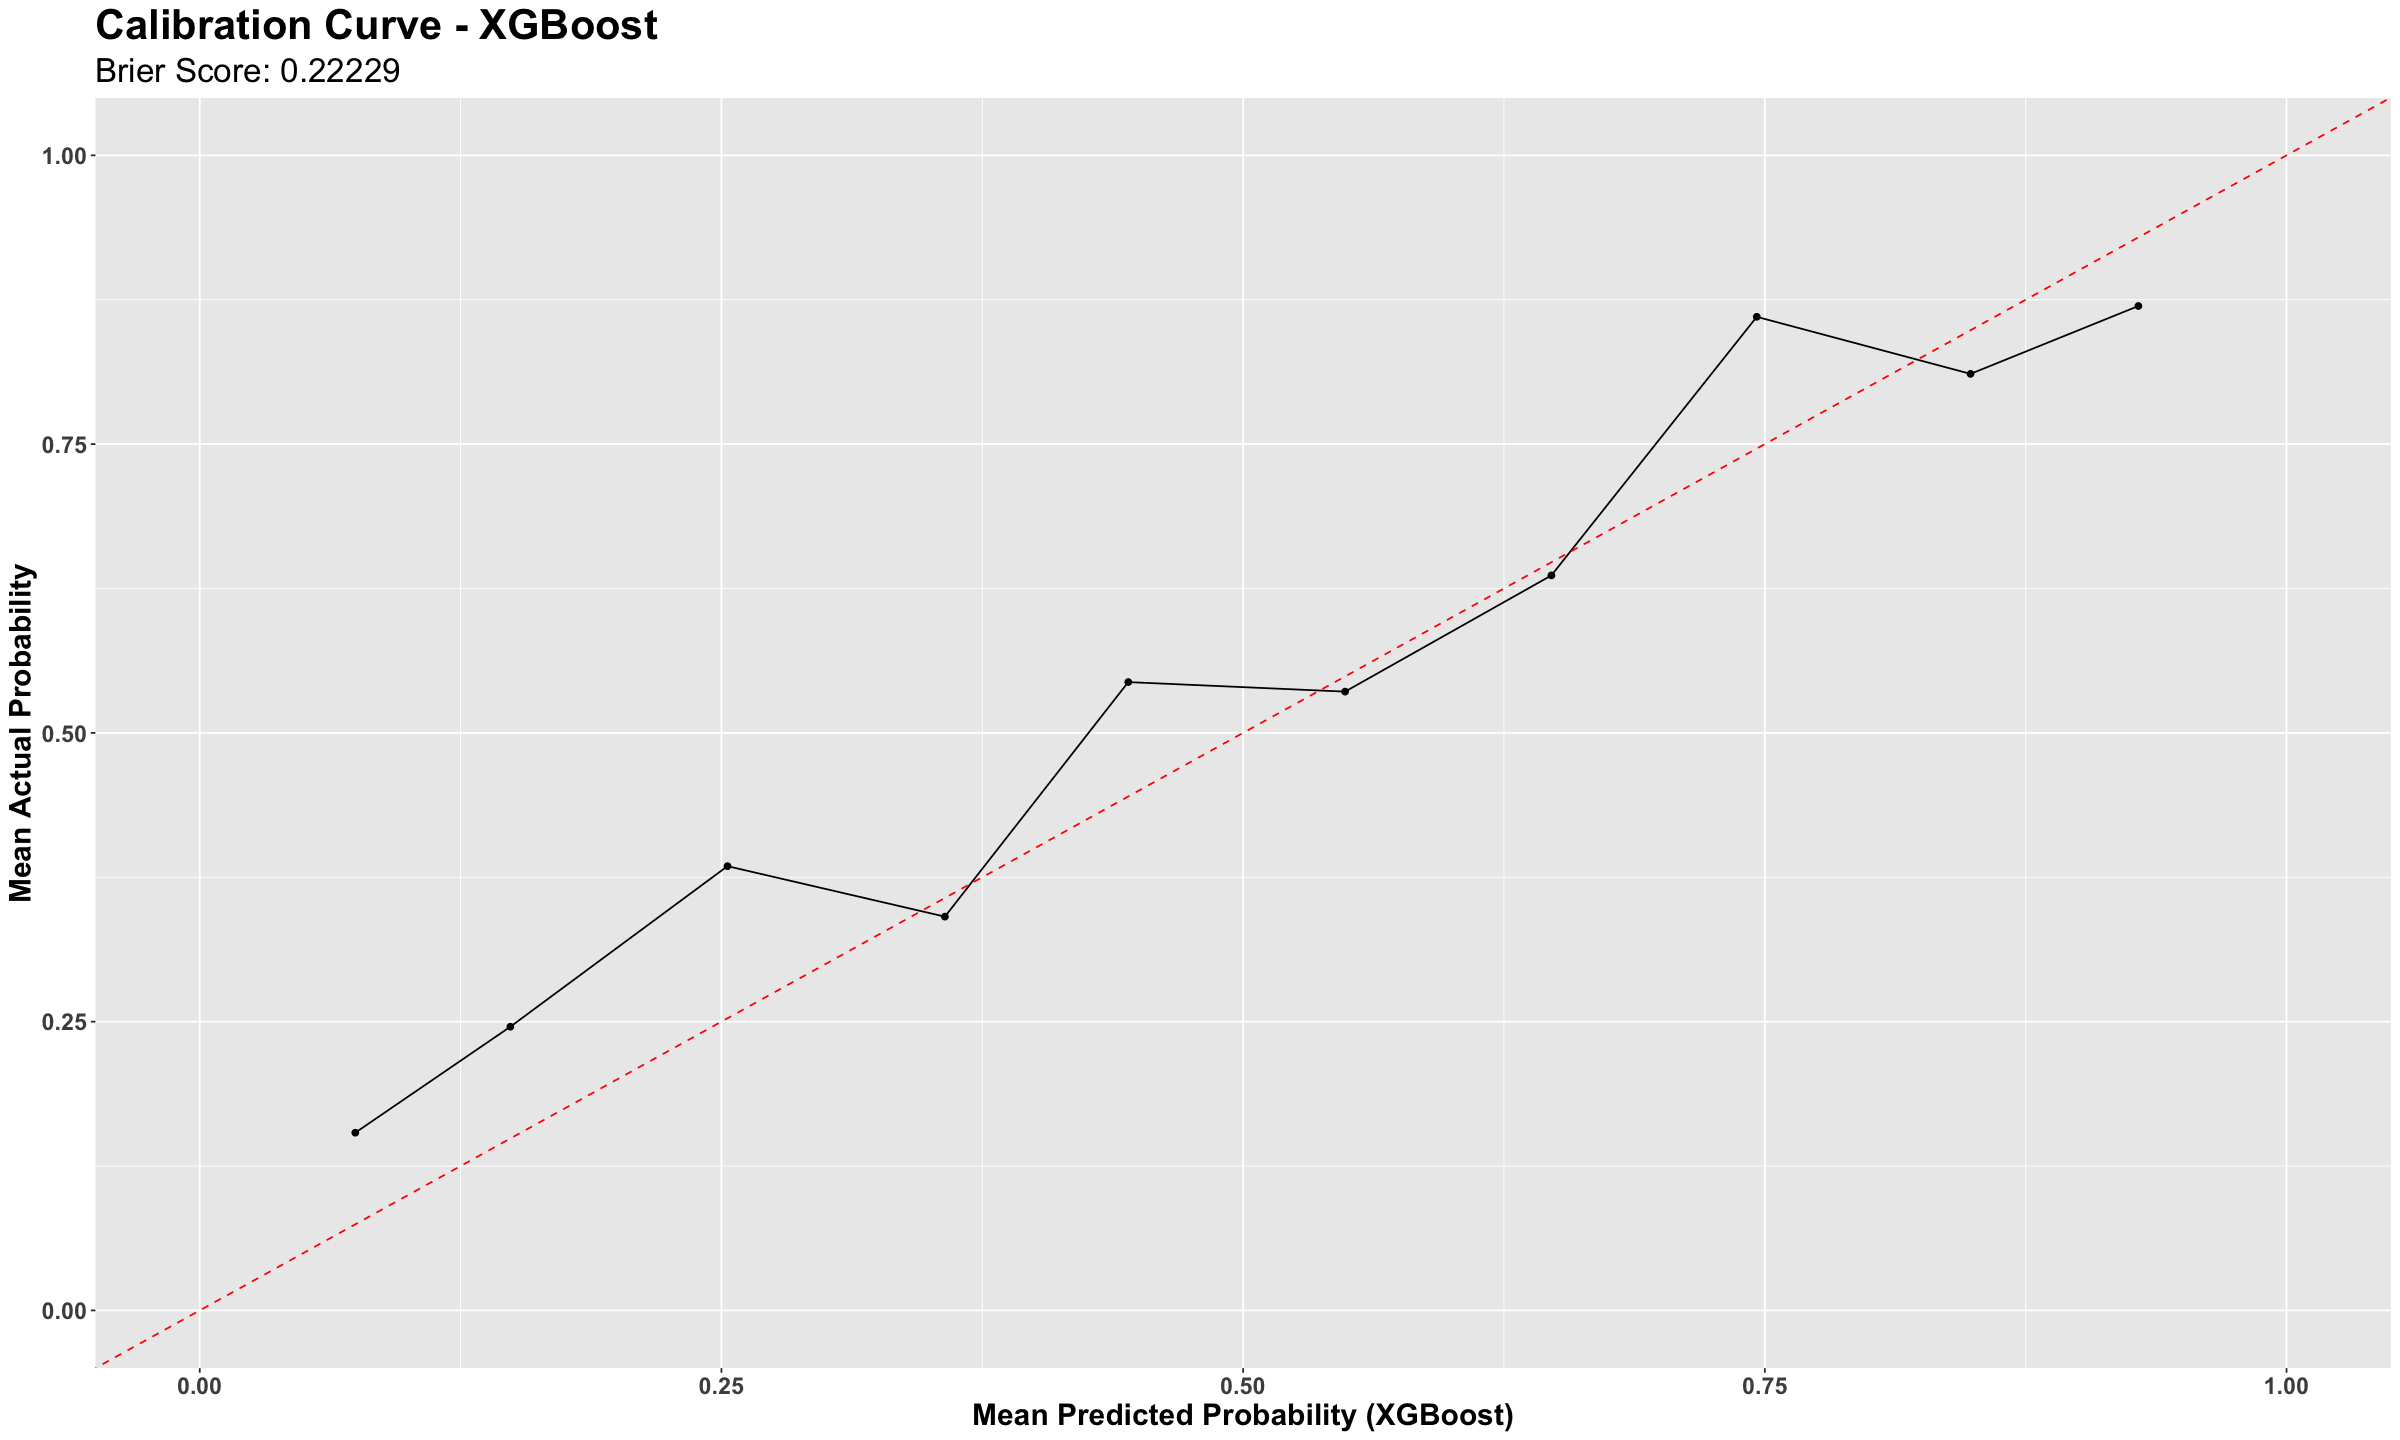

In [39]:
# ACTUAL MODEL
options(repr.plot.width=20, repr.plot.height=12)

params <- list(
  objective = "binary:logistic",
  eval_metric = "logloss", # Logarithmic Loss, suitable for probability estimation
  eta = 0.1,
  max_depth = 3, 
  colsample_bytree =1, 
  gamma = 0.2, 
  min_child_weight = 3, 
  subsample = 0.75
)

# Number of rounds for training
nrounds <- 100

# Train the model
set.seed(123) # for reproducibility
xgb_model <- xgboost(params = params, data = dtrain, nrounds = nrounds)

predicted_probabilities_xgb <- predict(xgb_model, dtest)

# You can calculate the Brier score for the XGBoost model predictions
brier_score_xgb <- mean((predicted_probabilities_xgb - test$p1_win)^2)
brier_score_xgb # 0.2219657

test$predicted_probability_xgb <- predicted_probabilities_xgb

# Create bins and calculate calibration data for XGBoost predictions
calibration_data_xgb <- test %>%
  mutate(predicted_bin_xgb = cut(predicted_probability_xgb, breaks = seq(0, 1, by = 0.1))) %>%
  group_by(predicted_bin_xgb) %>%
  summarise(mean_predicted_xgb = mean(predicted_probability_xgb),
            mean_actual_xgb = mean(p1_win))

# Plotting the calibration curve for XGBoost predictions
ggplot(calibration_data_xgb, aes(x = mean_predicted_xgb, y = mean_actual_xgb)) +
  geom_point() +
  geom_line() +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
  xlim(c(0, 1)) + ylim(c(0, 1)) +
  xlab("Mean Predicted Probability (XGBoost)") + ylab("Mean Actual Probability") +
  ggtitle("Calibration Curve - XGBoost", subtitle = "Brier Score: 0.22229") +
   theme(
    plot.title = element_text(size = 25, face = "bold"),
    plot.subtitle = element_text(size = 20, face = "plain"),
    axis.title.x = element_text(size = 18, face = "bold"),
    axis.title.y = element_text(size = 18, face = "bold"), 
    axis.text.x = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold")
  )



I know you didn't want long outputs, I made the initial mistake of including the plot output following the training. This takes a ton of time to correct, and I don't want to rerun everything.

## Model Comparison
- Looking at the brier scores, it appears that the models are essentially equal. However, the significance of the feautures we've engineered will increase over time as the sample size becomes larger. When this is the case, we would expect that the more complex model will outperform the simple linear one. 


In [ ]:


df_games <- df %>%
  mutate(total_games = p1_career_games + p2_career_games) %>%
  mutate(segment = cut(total_games, breaks = seq(0, max(total_games), by = 10), include.lowest = TRUE))

train_and_evaluate_log <- function(data) {
  model <- glm(p1_win ~ elo_before_player1 + elo_before_player2 + elo_diff, data = data, family = binomial)
  pred <- predict(model, data, type = "response")
  brier_score <- mean((pred - data$p1_win)^2)
  return(data.frame(brier_score = brier_score))
}


brier_scores_logistic <- df_games %>%
  group_by(segment) %>%
  do(train_and_evaluate_log(.)) %>%
  ungroup() %>%
  mutate( brier_score = round(brier_score, 5), 
    games_count = df_games %>% group_by(segment) %>% tally() %>% pull(n)) # Adding count of games


brier_scores_logistic$segment_numeric <- sapply(levels(brier_scores_logistic$segment), function(x) {
  # Remove the brackets and parenthesis
  x <- gsub("\\[|\\(", "", x)
  x <- gsub("\\]|\\)", "", x)
  # Split the string at the comma to get the interval bounds
  interval_bounds <- as.numeric(strsplit(x, ",")[[1]])
  # Calculate the interval
  max(interval_bounds)
})



# Function to train XGBoost model and calculate Brier score
# Function to train XGBoost model and calculate Brier score
train_and_evaluate_xgb <- function(data) {
  # Prepare the matrix for xgboost, exclude non-feature columns
  features_data <- as.matrix(data[, setdiff(names(data), c("p1_win", "total_games", "segment"))])
  dtrain <- xgb.DMatrix(data = features_data, label = data$p1_win)
  
  # Parameters for the XGBoost model
  params <- list(
    objective = "binary:logistic",
    eval_metric = "logloss",
    eta = 0.1,
    max_depth = 3,
    colsample_bytree = 1,
    gamma = 0.2,
    min_child_weight = 3,
    subsample = 0.75
  )
  
  # Number of rounds for training
  nrounds <- 100
  
  # Train the model
  set.seed(123) # for reproducibility
  xgb_model <- xgboost(params = params, data = dtrain, nrounds = nrounds, verbose = 0) # Set verbose = 0 to silence the training output
  
  # Predict probabilities
  pred <- predict(xgb_model, dtrain)
  
  # Calculate Brier score
  brier_score <- mean((pred - data$p1_win)^2)
  return(data.frame(brier_score = brier_score))
}

# Apply the function to each segment
brier_scores_xgb <- df_games %>%
  group_by(segment) %>%
  do(train_and_evaluate_xgb(.)) %>%
  ungroup() %>%
  mutate(brier_score = round(brier_score, 5)) %>%
  mutate(games_count = df_games %>% group_by(segment) %>% tally() %>% pull(n)) 


brier_scores_xgb$segment_numeric <- sapply(levels(brier_scores_xgb$segment), function(x) {
  # Remove the brackets and parenthesis
  x <- gsub("\\[|\\(", "", x)
  x <- gsub("\\]|\\)", "", x)
  # Split the string at the comma to get the interval bounds
  interval_bounds <- as.numeric(strsplit(x, ",")[[1]])
 
  max(interval_bounds)
})

brier_scores_logistic <- brier_scores_logistic %>% 
  mutate(model = "Logistic Regression")

brier_scores_xgb <- brier_scores_xgb %>% 
  mutate(model = "XGBoost")

combined_brier_scores <- bind_rows(brier_scores_logistic, brier_scores_xgb)

hist_data <- brier_scores_logistic %>%
  mutate(games_count_scaled = games_count / max(games_count) * max( brier_scores_logistic$brier_score))


`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 4 rows containing missing values (`geom_smooth()`)."


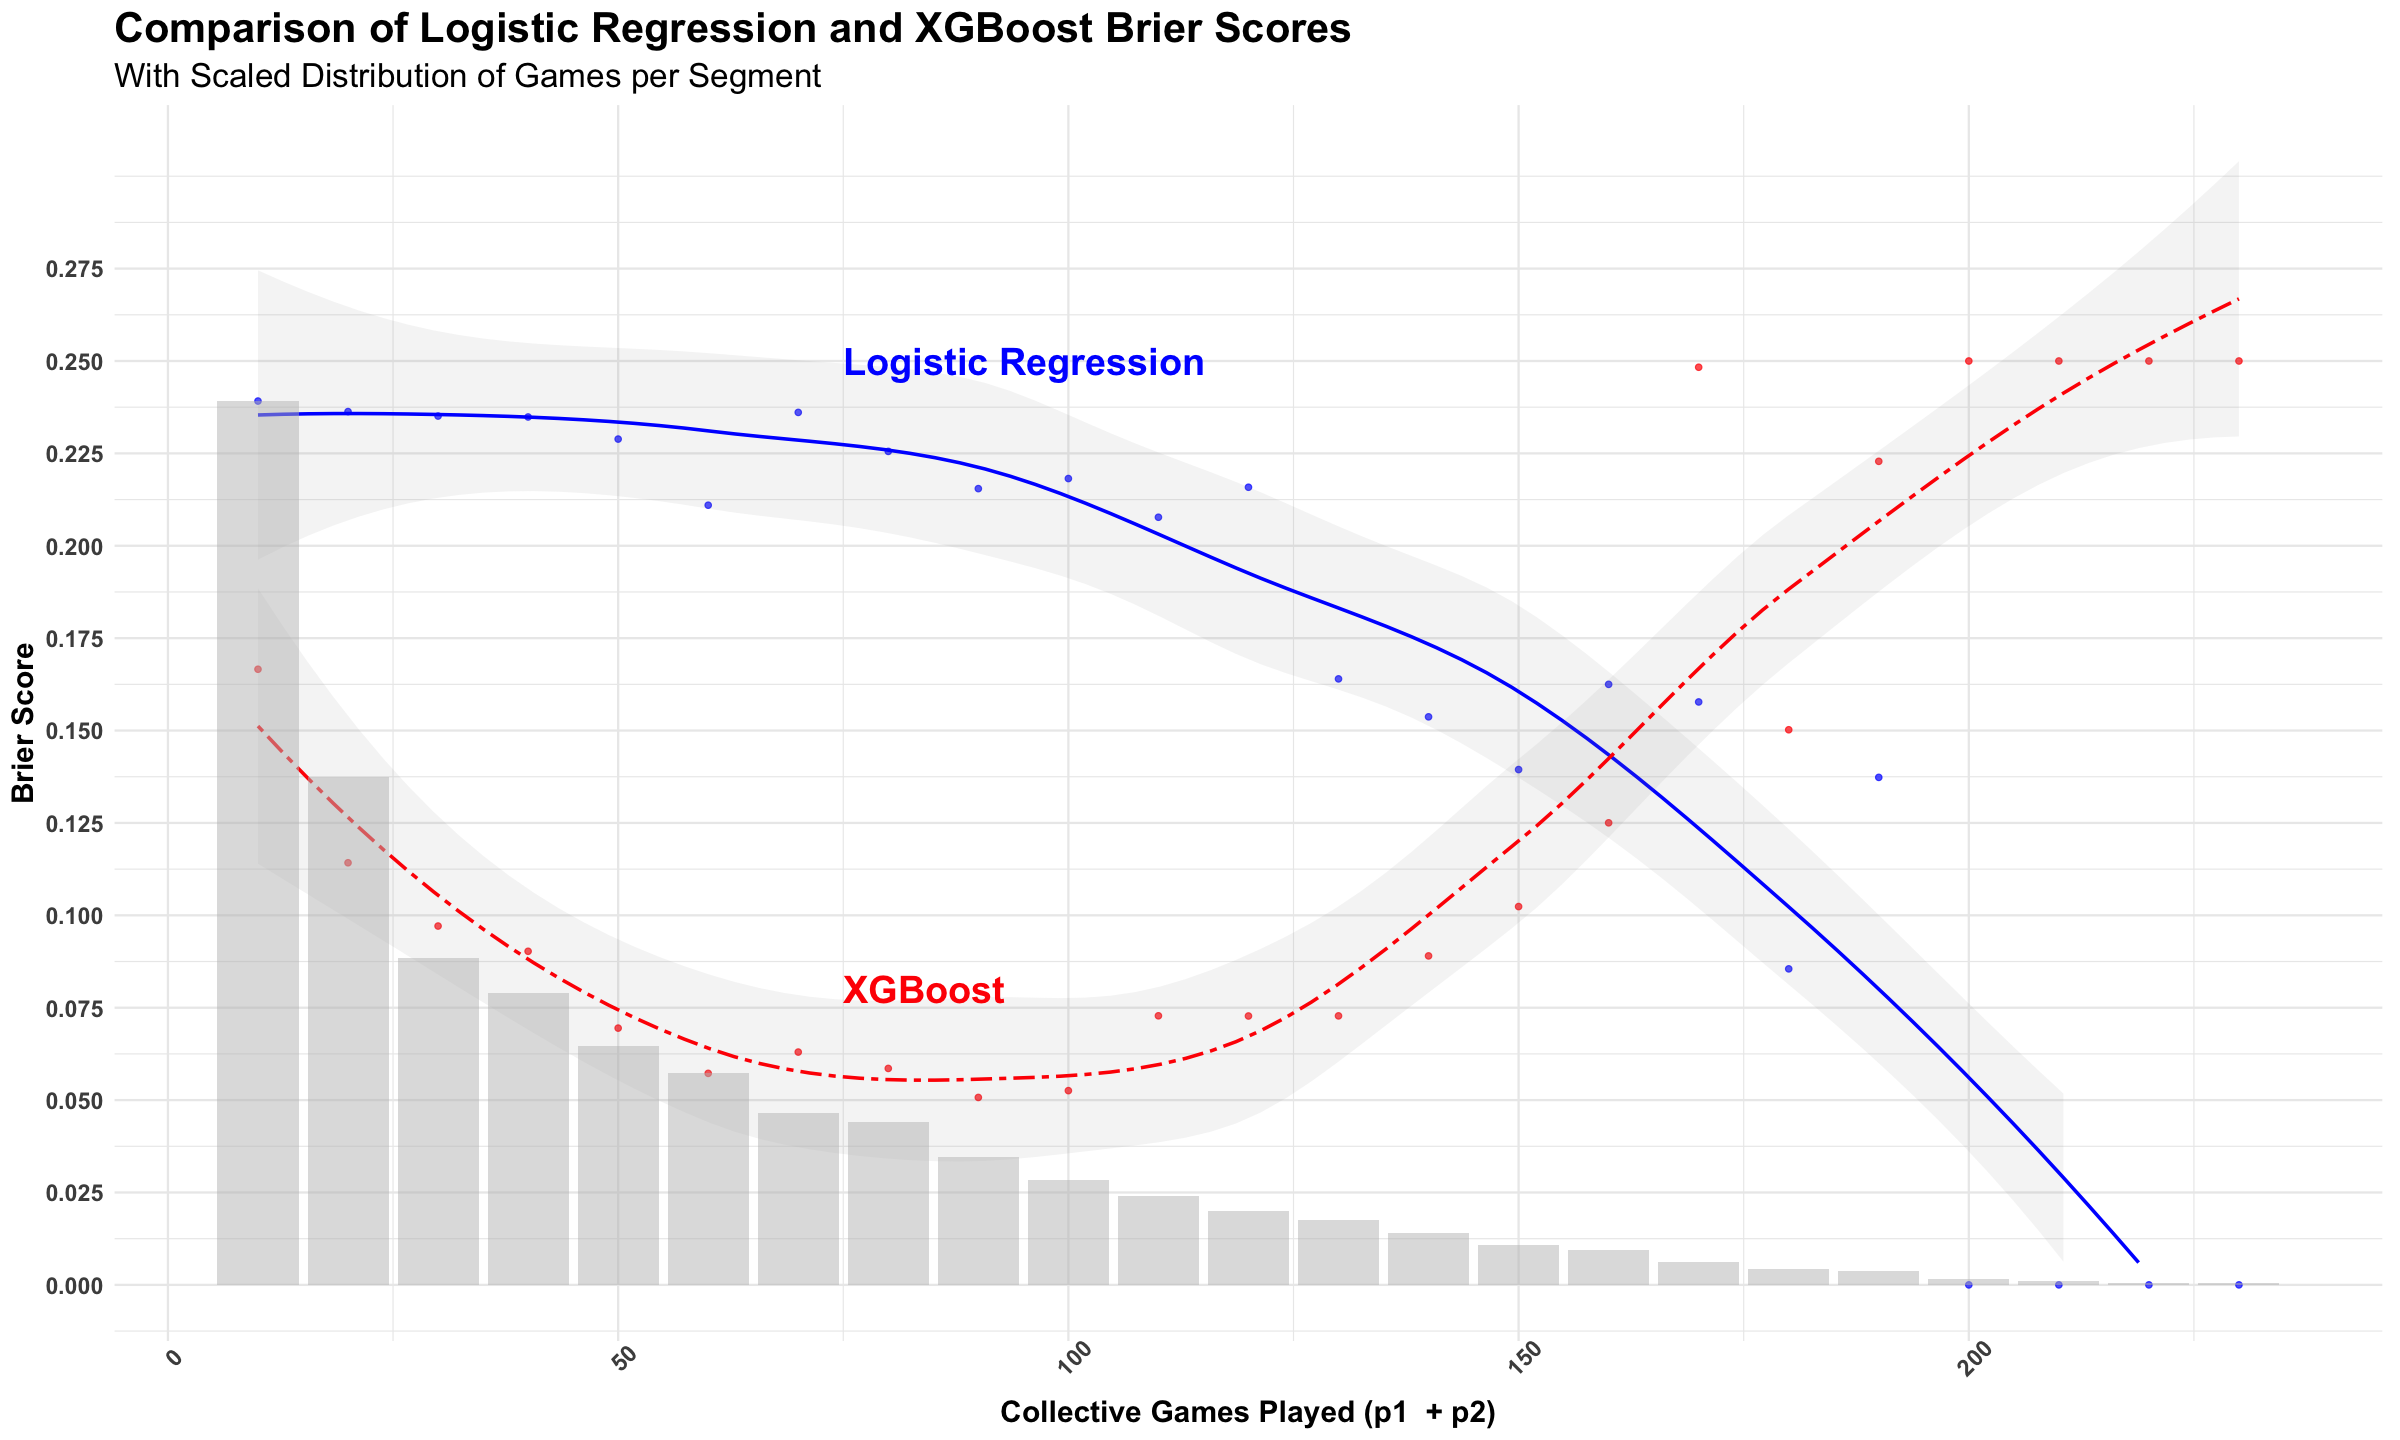

In [56]:
p <- ggplot() +
  geom_point(data = combined_brier_scores, aes(x = segment_numeric, y = brier_score, color = model), alpha = 0.7) +
  geom_smooth(data = combined_brier_scores, aes(x = segment_numeric, y = brier_score, linetype = model, color = model), 
              method = "loess", se = TRUE, size = 1, alpha = 0.1) +
  theme_minimal(base_size = 14) +
  labs(title = "Comparison of Logistic Regression and XGBoost Brier Scores",
       subtitle = "With Scaled Distribution of Games per Segment",
       x = "Collective Games Played (p1  + p2)")+
       geom_bar(data = hist_data, aes(x = segment_numeric, y = games_count_scaled), 
           stat = "identity", fill = "grey", alpha = 0.5) +
  scale_y_continuous(sec.axis = sec_axis(~ ., name = NULL, labels = NULL),
                     breaks = seq(0, 0.275, by = 0.025), 
                     limits = c(0, NA), name = "Brier Score") +  # Secondary axis for the histogram (not used for scaling)
  scale_color_manual(values = c("Logistic Regression" = "blue", "XGBoost" = "red")) +
  scale_linetype_manual(values = c("Logistic Regression" = "solid", "XGBoost" = "twodash")) +
  theme(legend.position = "right",
            legend.title = element_text(size = 18, face = "bold"), # Style for the legend title
            legend.text = element_text(size = 18),
        plot.title = element_text(size = 25, face = "bold"),
        axis.text.x = element_text(angle = 45,  size = 14, face = "bold"),
        axis.text.y = element_text(size = 14, face = "bold"),
        axis.title.x = element_text(size = 18, face = "bold"),
        axis.title.y = element_text(size = 18, face = "bold"), 
        plot.subtitle = element_text(size = 20, face = "plain")
       )+
      annotate("text", x = 75, y = 0.25, label = "Logistic Regression", hjust = 0, size = 8, color = "blue", fontface = "bold") +
      annotate("text", x = 75, y = 0.08, label = "XGBoost", hjust = 0, size = 8, color = "red", fontface = "bold") +
  guides(color = guide_legend(title = "Model Type"),
         linetype = guide_legend(title = "Model Type"))+
         theme(legend.position = "none")

p

## Discussion:

As we can see  the XGBOOST model outperforms the linear model for a majority of the subsets data. When trained on the complete dataset, XGBOOST becomes overfit to the early stages of the data, and struggles to adapt when it's exposed to new, more robust data. We can see our feature engineering begins to pay off significantly after each player in a given match has played more than 20 games. The XGBOOST model is extremely strong when it's exposed to a decently large sample of games with stabilized features (Elo, Winning%, etc.), suggesting that it will perform exceptionally well when predicting future matches. Before digging deeper, I was ready to consider the two models as equals - given their nearly identical Brier score when exposed to the full dataset. However, by rigorously comparing the models with respect to their innate strengths and weaknesses we are able to understand that the more complex model is significantly more powerful than its simple linear counterpart. Moving forward, I think there are a lot of ways this model could be improved. In addition to tuning the models hyper parameters, it would make sense to tune the specific values of the dynamic ELO formula. That being said, the final model is extremely strong, and would only continue to improve with additional data.

## References: 

Elo rating - HexWiki. (n.d.). https://www.hexwiki.net/index.php/Elo_rating

FIDE Ratings and Statistics. (n.d.). https://ratings.fide.com/

Stankovic, S. (2023, July 25). Elo Rating System - Stanislav Stankovic - Medium. Medium. https://stanislav-stankovic.medium.com/elo-rating-system-6196cc59941e

Veisdal, J. (2021, December 11). The Mathematics of Elo Ratings - Cantor’s Paradise. Medium. https://www.cantorsparadise.com/the-mathematics-of-elo-ratings-b6bfc9ca1dba


